In [24]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parsing_utils import *
from utils.utils import *


"""
Plots we want:
    - more plans being explored in each template when prioritizing
    - final qerr on the worst / best queries
        - hypothesis: worst jerr queries, prioritization will actually improve qerr
    - plot evolution of qerr vs jerr side by side for some queries
    - is each ideal plan in the explored plans at least once?
"""
RES_DIR = "./flow_results_selectivity/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
all_df = get_all_training_df(RES_DIR)

no7a-baseline2-mscn-df:10-nn:1:256-0.0--D0.1-103
alg:  mscn
flow f:  1
special cases for flow features 
no7a-LR0001-mscn-df:10-nn:1:256-loss:flow_loss2-0.0--D0.1-343
alg:  mscn
flow f:  1
special cases for flow features 
mscn-df:10-nn:1:256-loss:flow_loss2-0.0--D0.1-986
alg:  mscn
flow f:  1
special cases for flow features 


In [34]:
set(all_df["flow_features"])

{'', 'flow_features'}

In [35]:
cols = ["alg", "loss_func", "flow_features"]
all_df['alg_name'] = all_df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

df = all_df[all_df["template"] == "all"]
df = df[df["num_tables"] == "all"]
df = df[df["summary_type"] == "mean"]
#df['alg_name'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

all_df = all_df[all_df["template"] != "all"]
all_df = all_df[all_df["summary_type"] == "mean"]

print(set(df["alg_name"]))
print(set(all_df["alg_name"]))

{'mscn_flow_loss2_flow_features', 'mscn_flow_loss2_', 'mscn_qloss_'}
{'mscn_flow_loss2_flow_features', 'mscn_flow_loss2_', 'mscn_qloss_'}


In [46]:
HUE_COLORS = {'mscn_qloss_':'red', \
              'mscn_flow_loss2_':'blue',  \
              'mscn_flow_loss2_flow_features': 'green'}
#mscn_flow_loss2_flow_features'
print(HUE_COLORS)

{'mscn_qloss_': 'red', 'mscn_flow_loss2_': 'blue', 'mscn_flow_loss2_flow_features': 'green'}


# Three Models

## mscn_flow_loss2_: Flow Loss based model with selectivity normalization (blue)
## mscn_flow_loss2_: Flow Loss based model with selectivity normalization + flow features (green)
## mscn_qloss_: Q-Loss model with selectivity normalization (red)

# Gradients

* Only recorded for the Flow_Loss model here.
* mean (abs (gradient_vec)) where greadient_vec is calculated per query at each update step

{'mscn_qloss_': 'red', 'mscn_flow_loss2_': 'blue', 'mscn_flow_loss2_flow_features': 'green'}


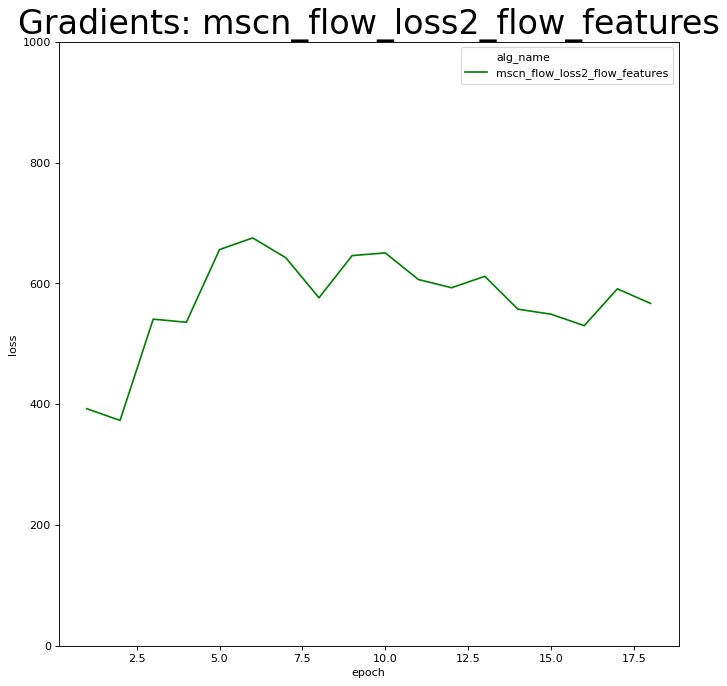

<Figure size 432x288 with 0 Axes>

In [49]:
def plot_grad(df, alg_name, lr, ylim):
    fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    cur_df = df[df["alg_name"] == alg_name]
    cur_df = cur_df[cur_df["lr"] == lr]
    print(HUE_COLORS)
    sns.lineplot(x="epoch", y="loss", data=cur_df, hue="alg_name", palette=HUE_COLORS, ci=None)
    plt.ylim(ylim)
    alg_name = list(set(cur_df["alg_name"]))[0]
    plt.title("Gradients: " + alg_name, fontsize=30)
    #plt.yscale("log")
    plt.show()
    plt.clf()

# Gradients
grad_df = df[df["loss_type"] == "gradients"]

#plot_grad(grad_df, "flow_loss2", 0.001, (-100,100))
plot_grad(grad_df, "mscn_flow_loss2_flow_features", 0.0001, (0, 1000))
#plot_grad(grad_df, "qloss", 0.001, (None, None))

# Mean Gradients across each template

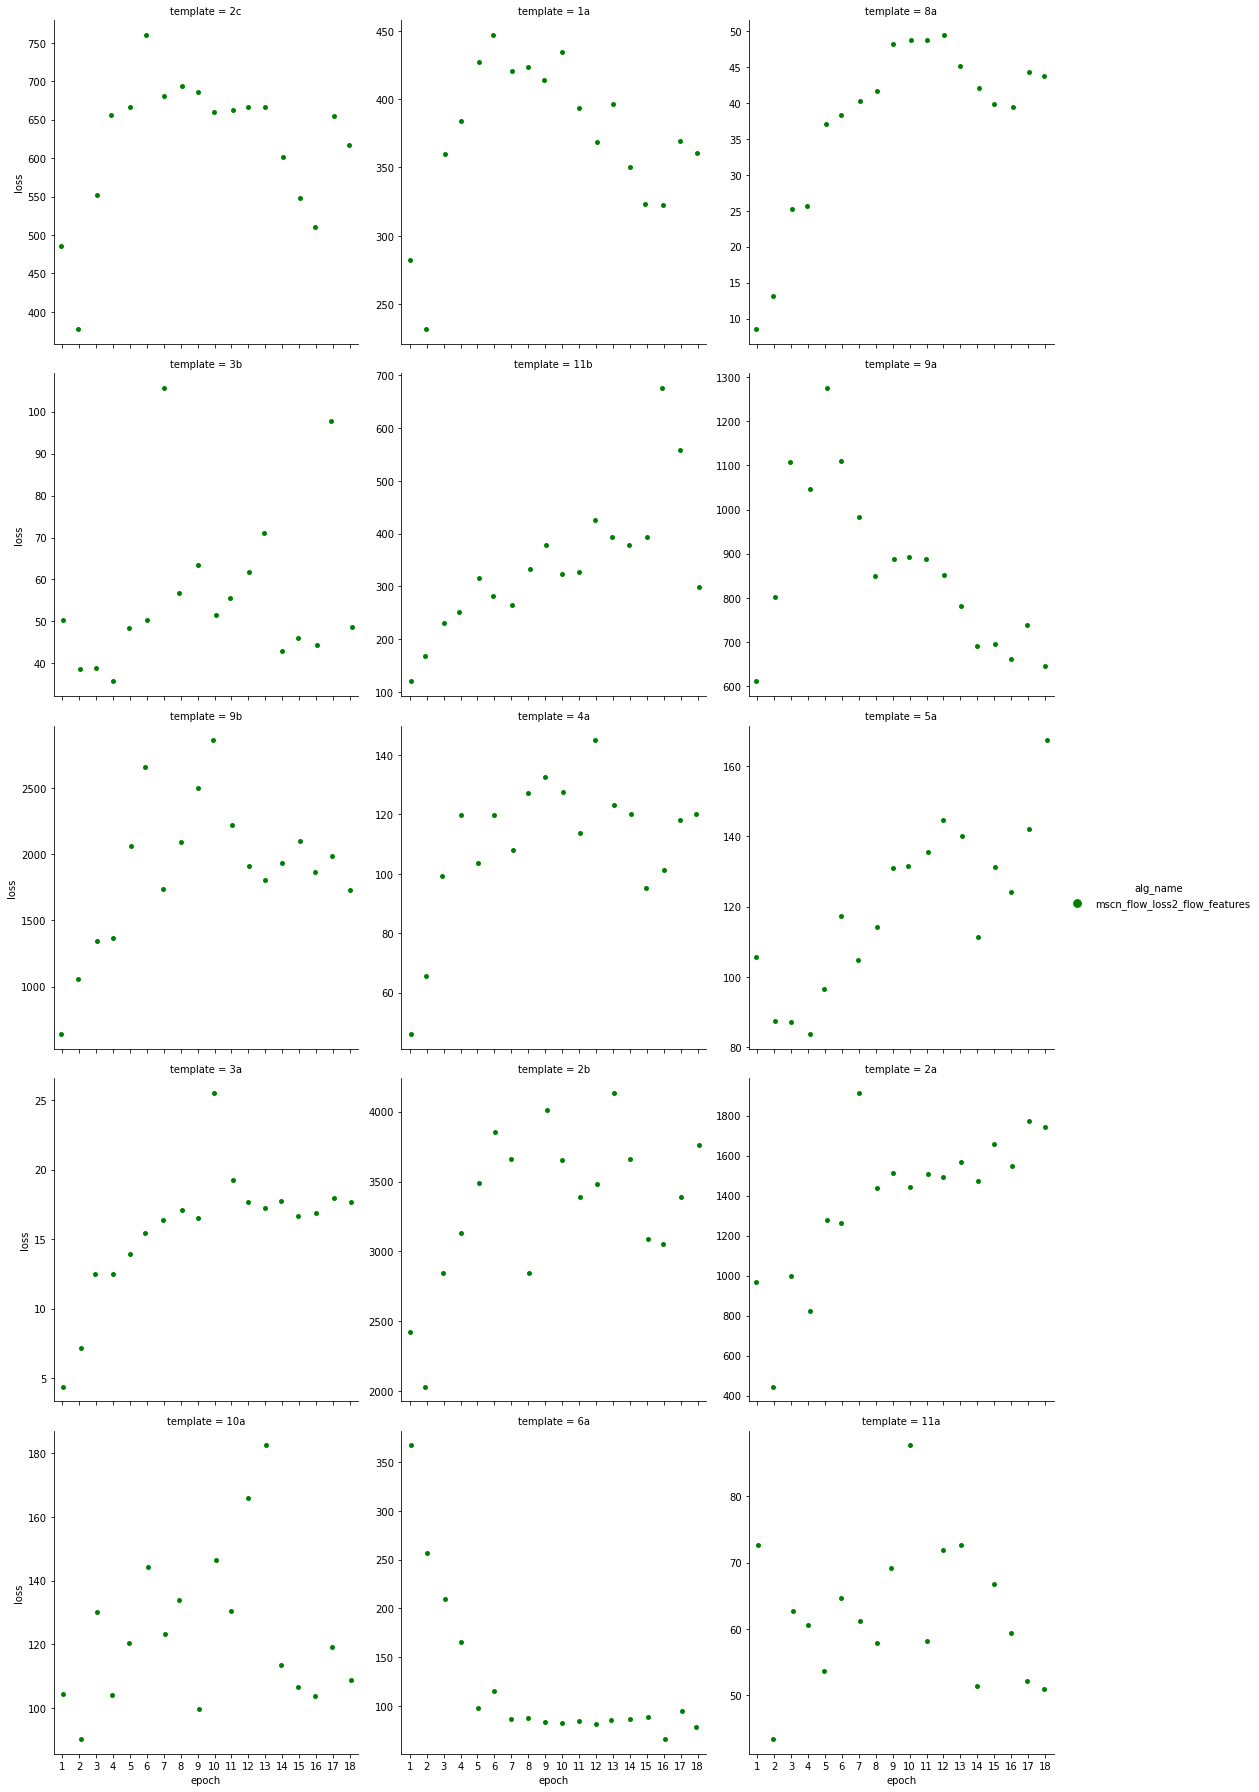

In [51]:
grad_df = all_df[all_df["loss_type"] == "gradients"]
grad_df = grad_df[grad_df["flow_features"] != ""]
#fig = plt.figure(figsize=(50, 50), dpi= 80, facecolor='w', edgecolor='k')
fg = sns.catplot(x = "epoch", y = "loss", data=grad_df, col="template", col_wrap=3, sharex=True, 
                 sharey=False, hue="alg_name", palette = HUE_COLORS)
plt.show()

# Loss Results

## Train - Test results over all the losses, and 6000+ queries each in the training / test sets

In [52]:
title_fmt = "Mean-{}-{}"
def plot_loss(df, loss_type, samples_type, yscale):

    fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    title = title_fmt.format(loss_type, samples_type)
    plt.title(title, fontsize=50)
    cur_df = df[df["samples_type"] == samples_type]
    cur_df = cur_df[cur_df["loss_type"] == loss_type]
    
    scale_df = df[df["epoch"] == 4]
    scale_df = scale_df[scale_df["loss_type"] == loss_type]
    maxy = max(scale_df["loss"])
    miny = min(cur_df["loss"])
    #print(cur_df)
    sns.lineplot(x="epoch", y="loss", hue="alg_name", data=cur_df, palette=HUE_COLORS, ci=None)
    plt.ylim((miny,maxy))
    #plt.ylim((0,10000))
    plt.yscale(yscale)
    plt.rc('legend', fontsize=10, loc="lower left")    # legend fontsize
    plt.show()


template_title_fmt = "All-Templates-{}-{}"
def plot_loss_template(df, loss_type, samples_type, yscale):
    title = template_title_fmt.format(loss_type, samples_type)
    loss_df = df[df["loss_type"] == loss_type]
    loss_df = loss_df[loss_df["samples_type"] == samples_type]
    scale_df = df[df["epoch"] == 4]
    scale_df = scale_df[scale_df["loss_type"] == loss_type]
    maxy = max(scale_df["loss"])
    miny = min(loss_df["loss"])

    #fig = plt.figure(figsize=(50, 50), dpi= 80, facecolor='w', edgecolor='k')
    fg = sns.catplot(x = "epoch", y = "loss", data=loss_df, col="template", col_wrap=3, sharex=True, 
                 sharey=True, hue="alg_name", palette=HUE_COLORS)
    fg.set(ylim=(miny,maxy))
    fg.set(yscale=yscale)
   # fg.fig.suptitle(title, fontsize=50)
    fg.fig.suptitle(title,
                x=0.5, y=.99, horizontalalignment='center',
                verticalalignment='top', fontsize = 40)
    fg.despine(left=True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

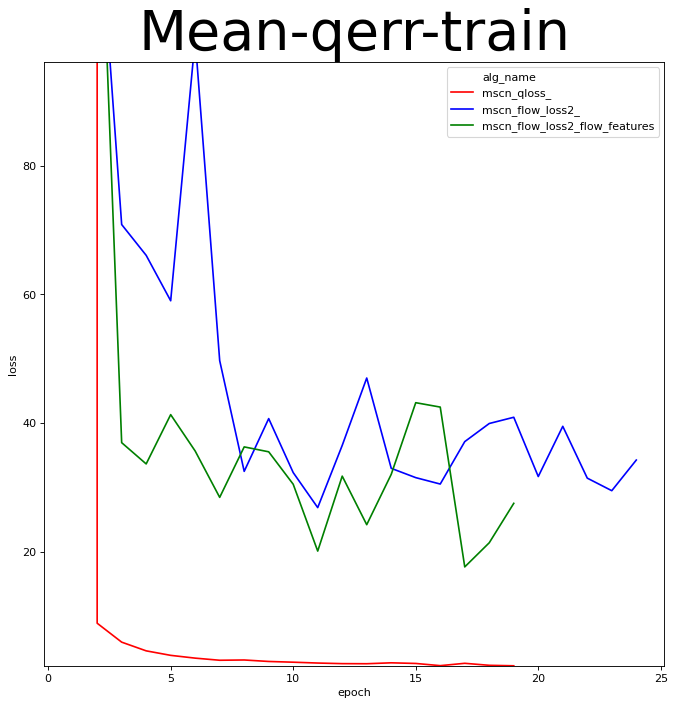

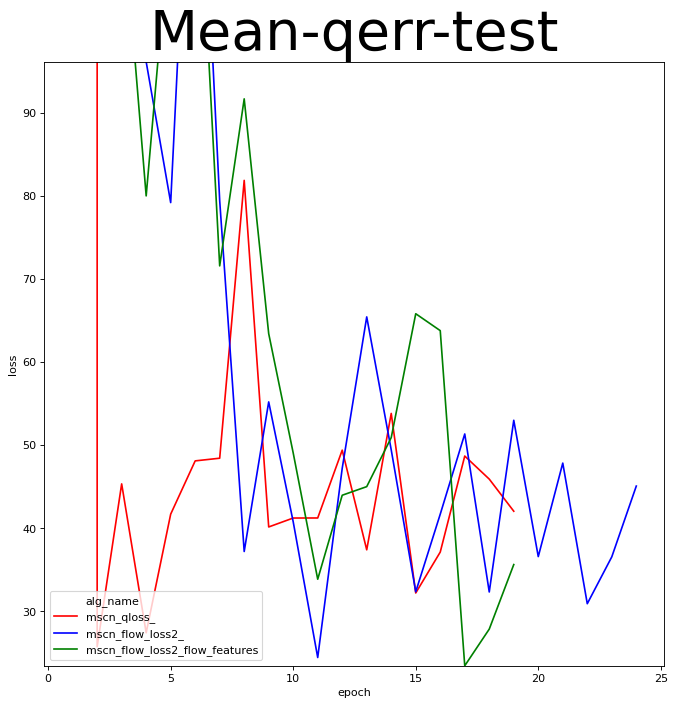

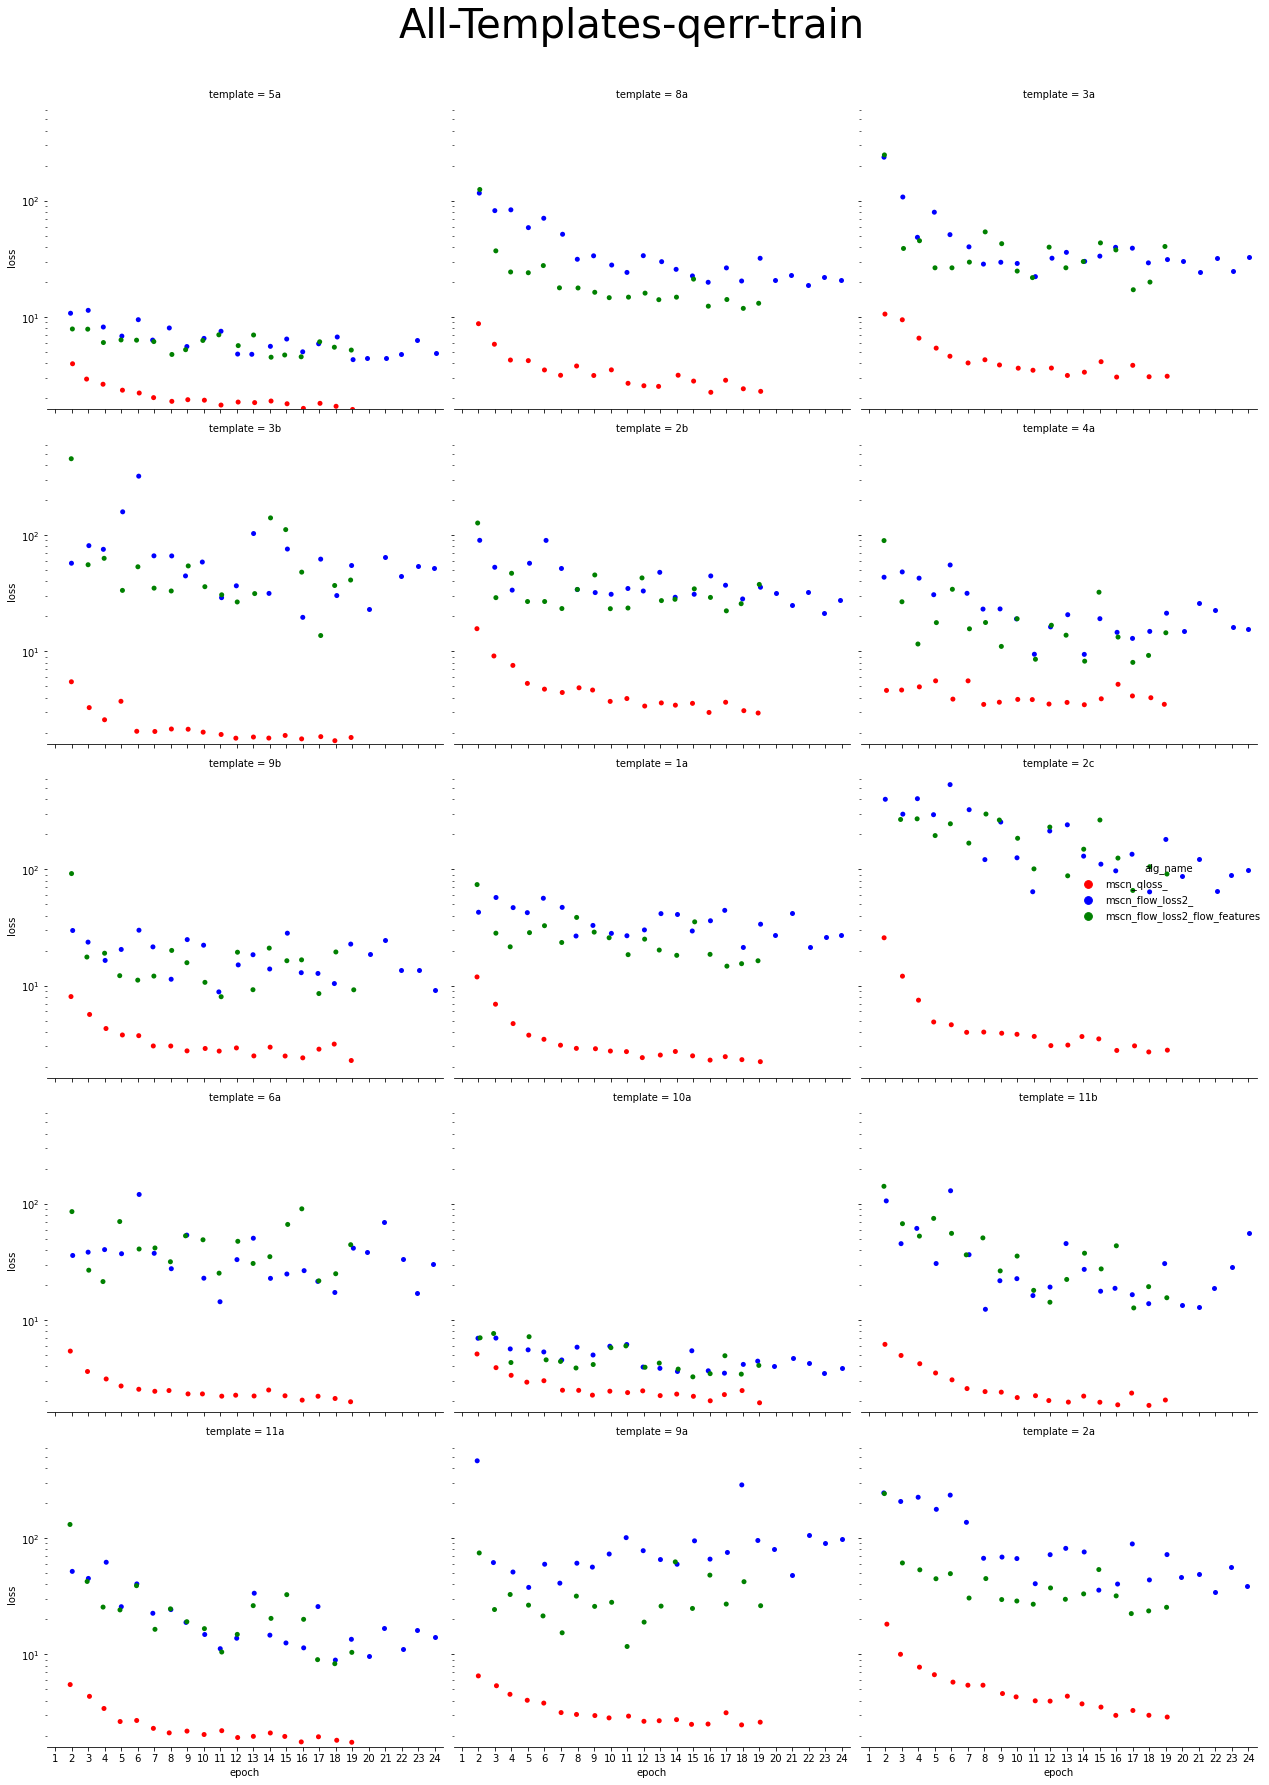

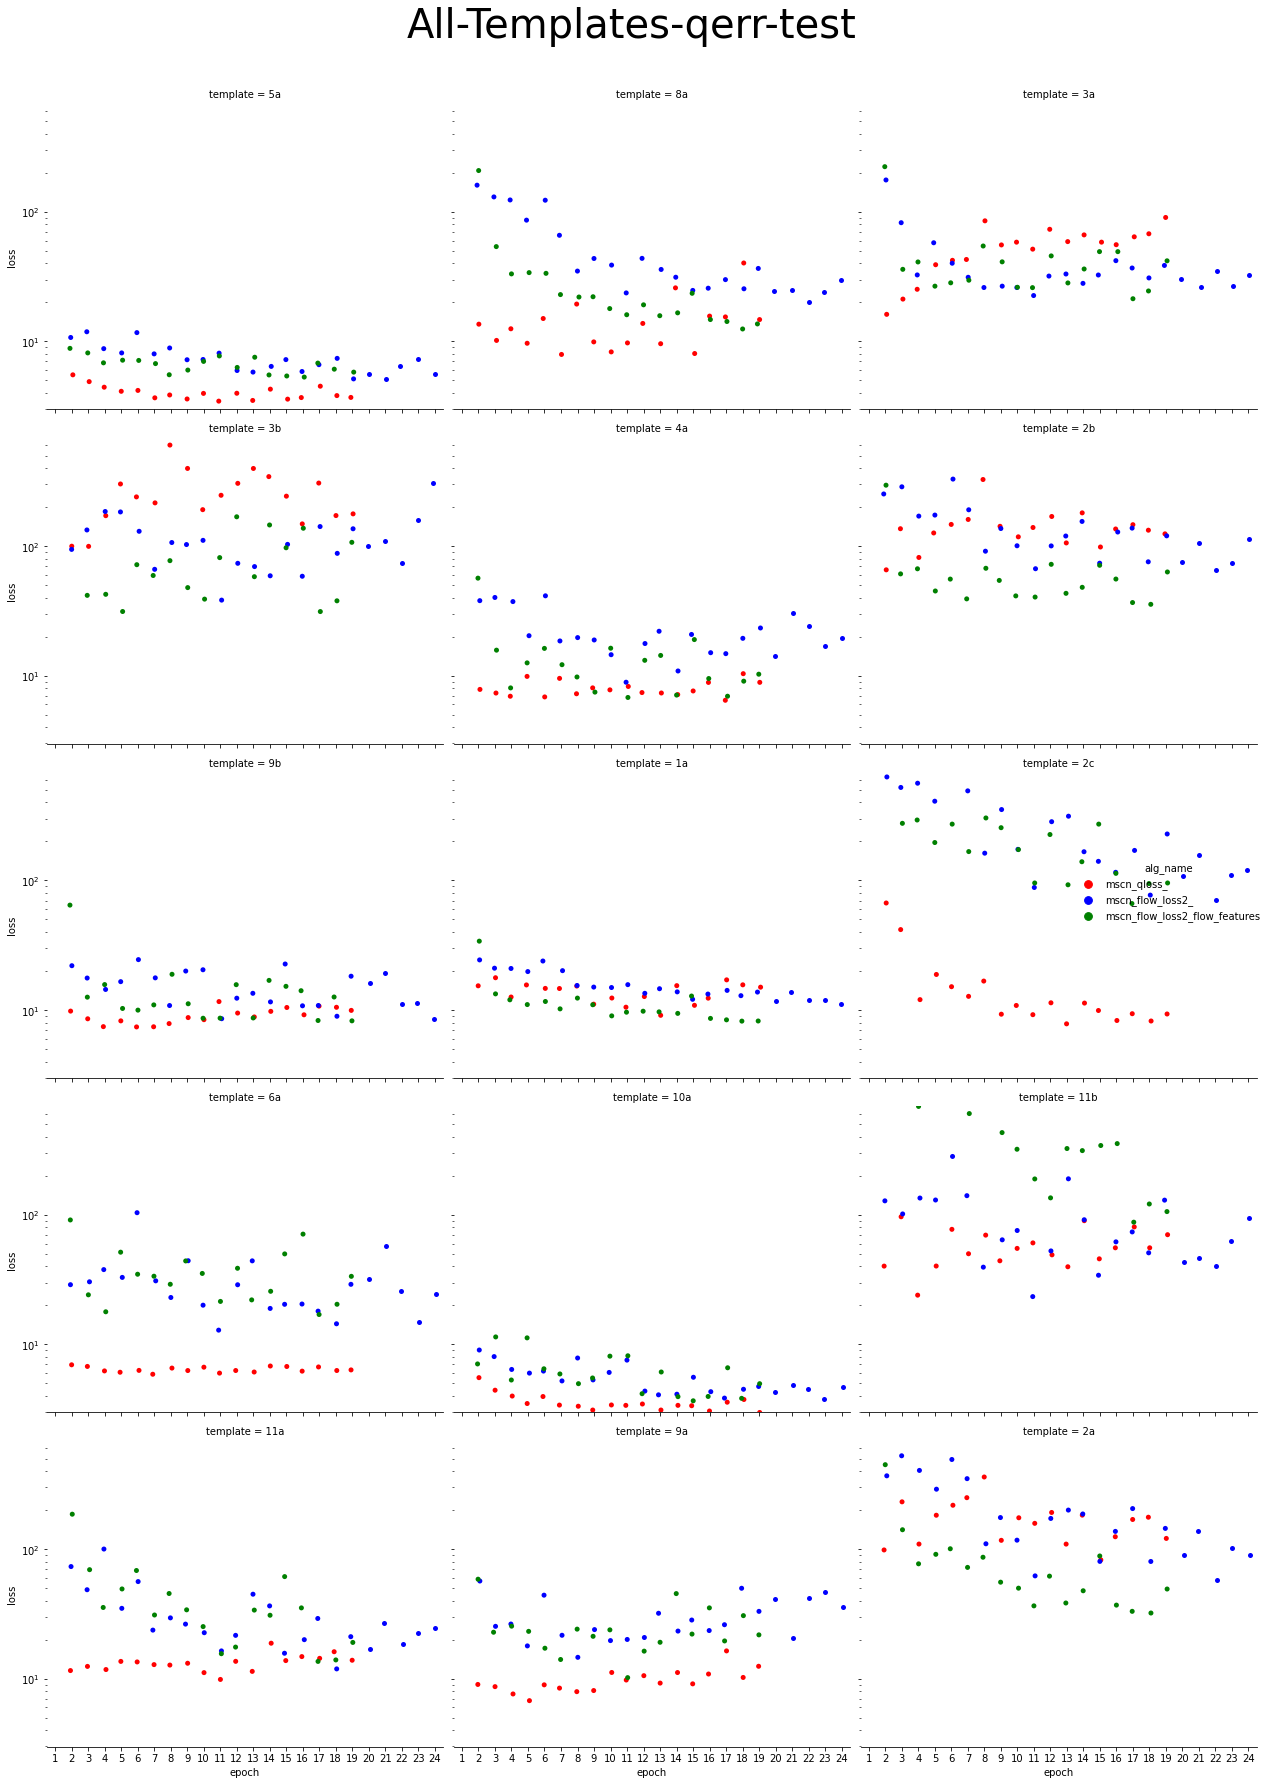

In [53]:
plot_loss(df, "qerr", "train", "linear")
plot_loss(df, "qerr", "test", "linear")
plot_loss_template(all_df, "qerr", "train", "log")
plot_loss_template(all_df, "qerr", "test", "log")


# Flow Error

## Flow_Loss - Optimal_Flow_loss

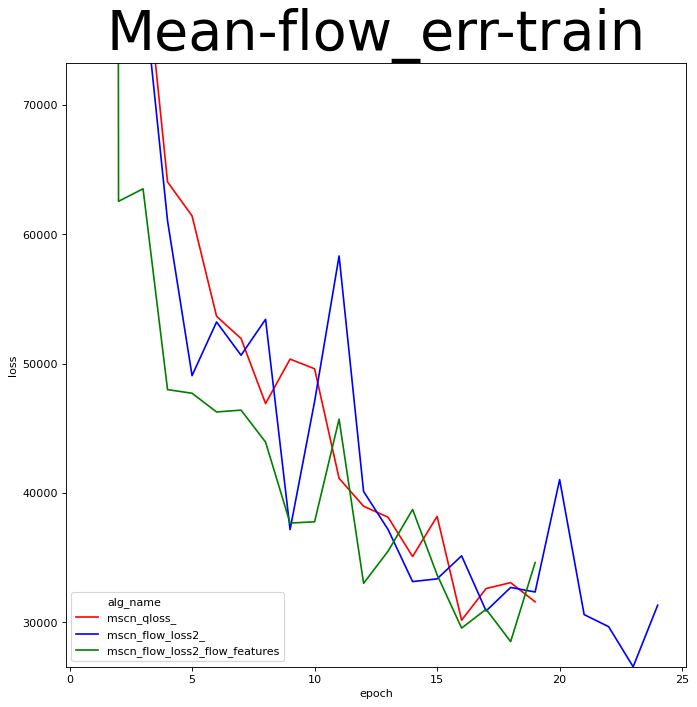

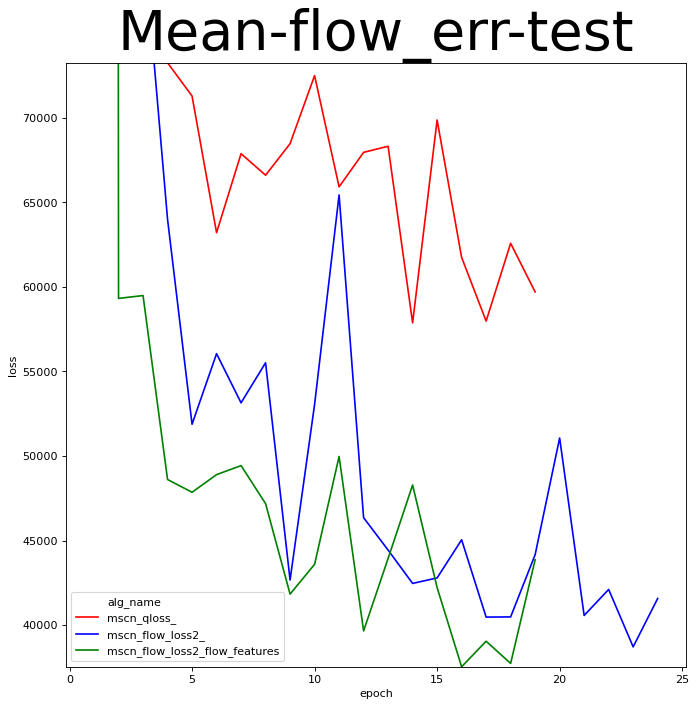

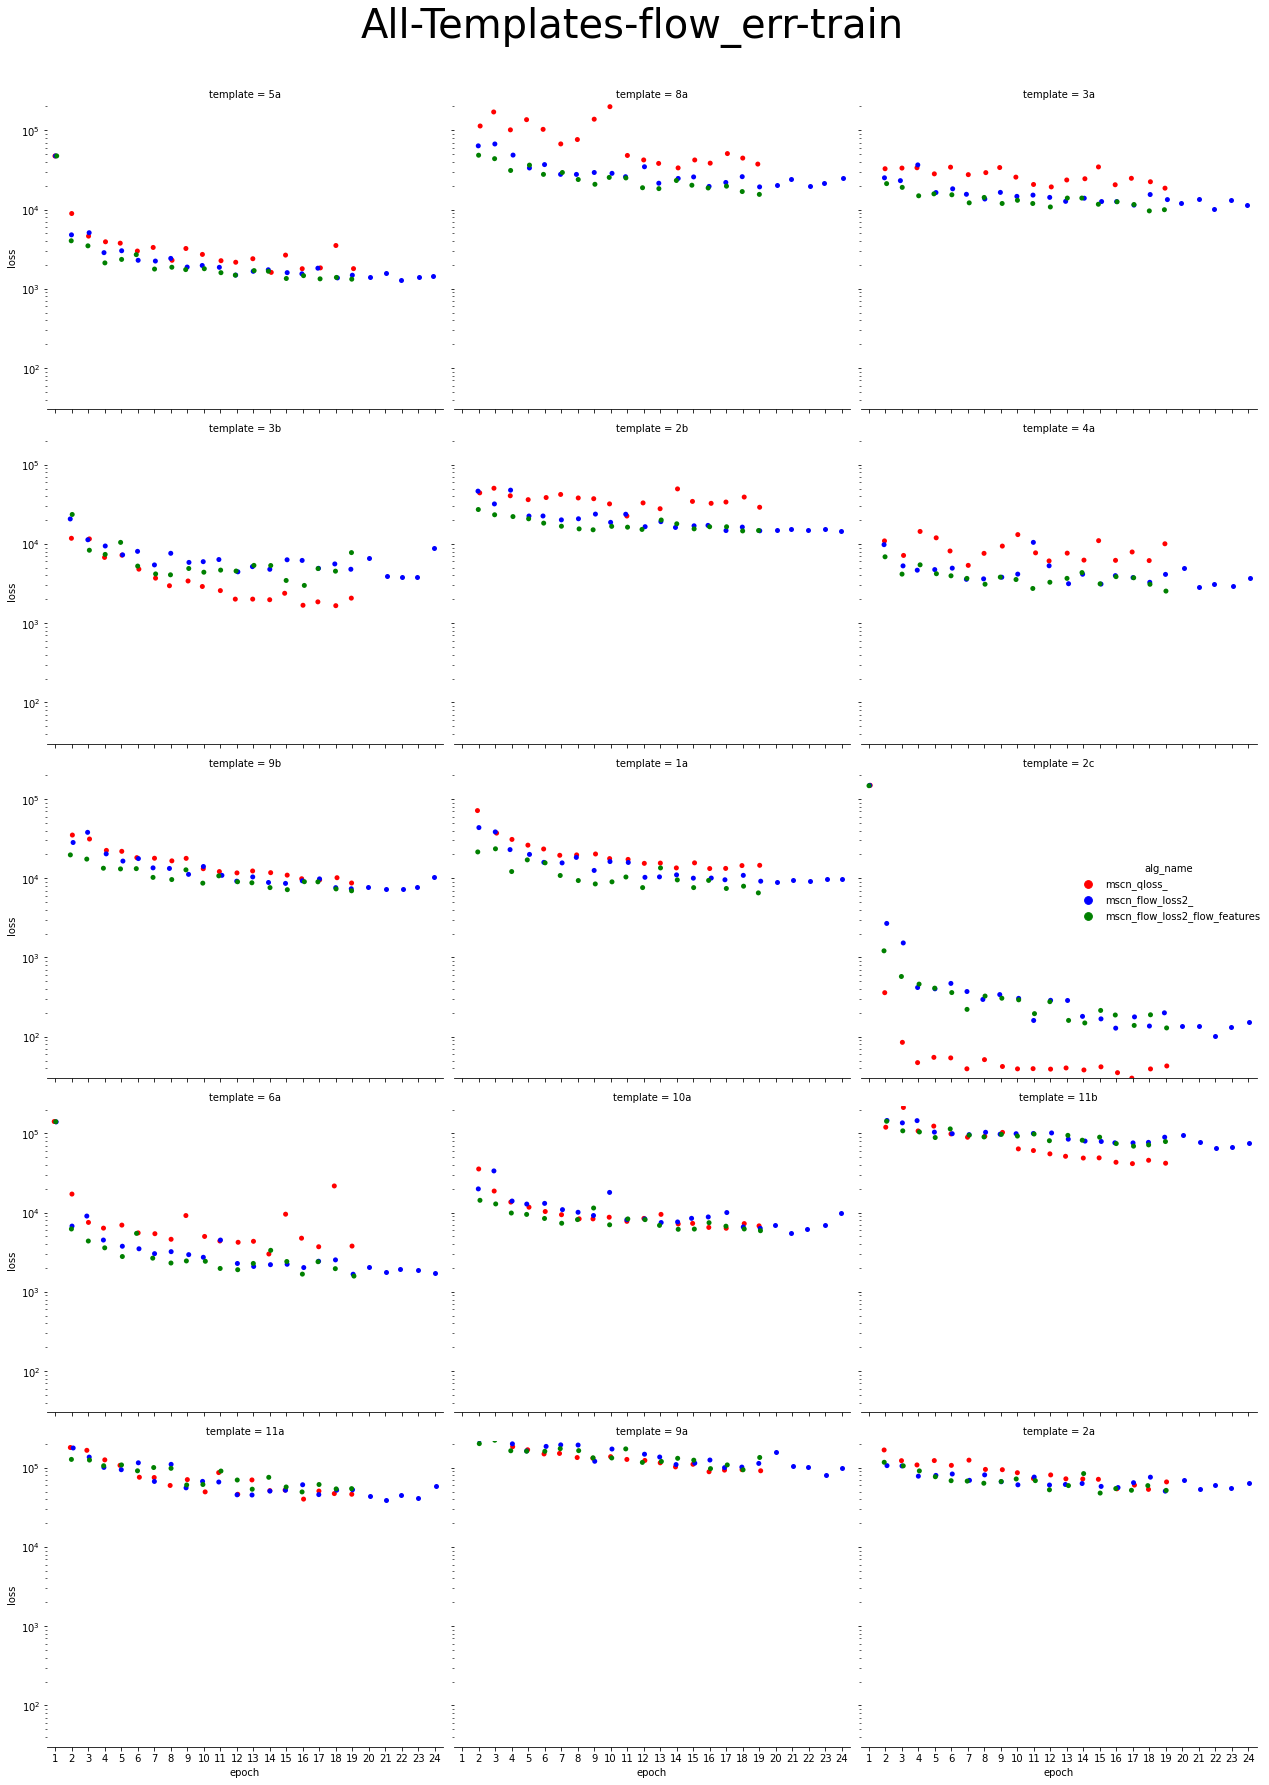

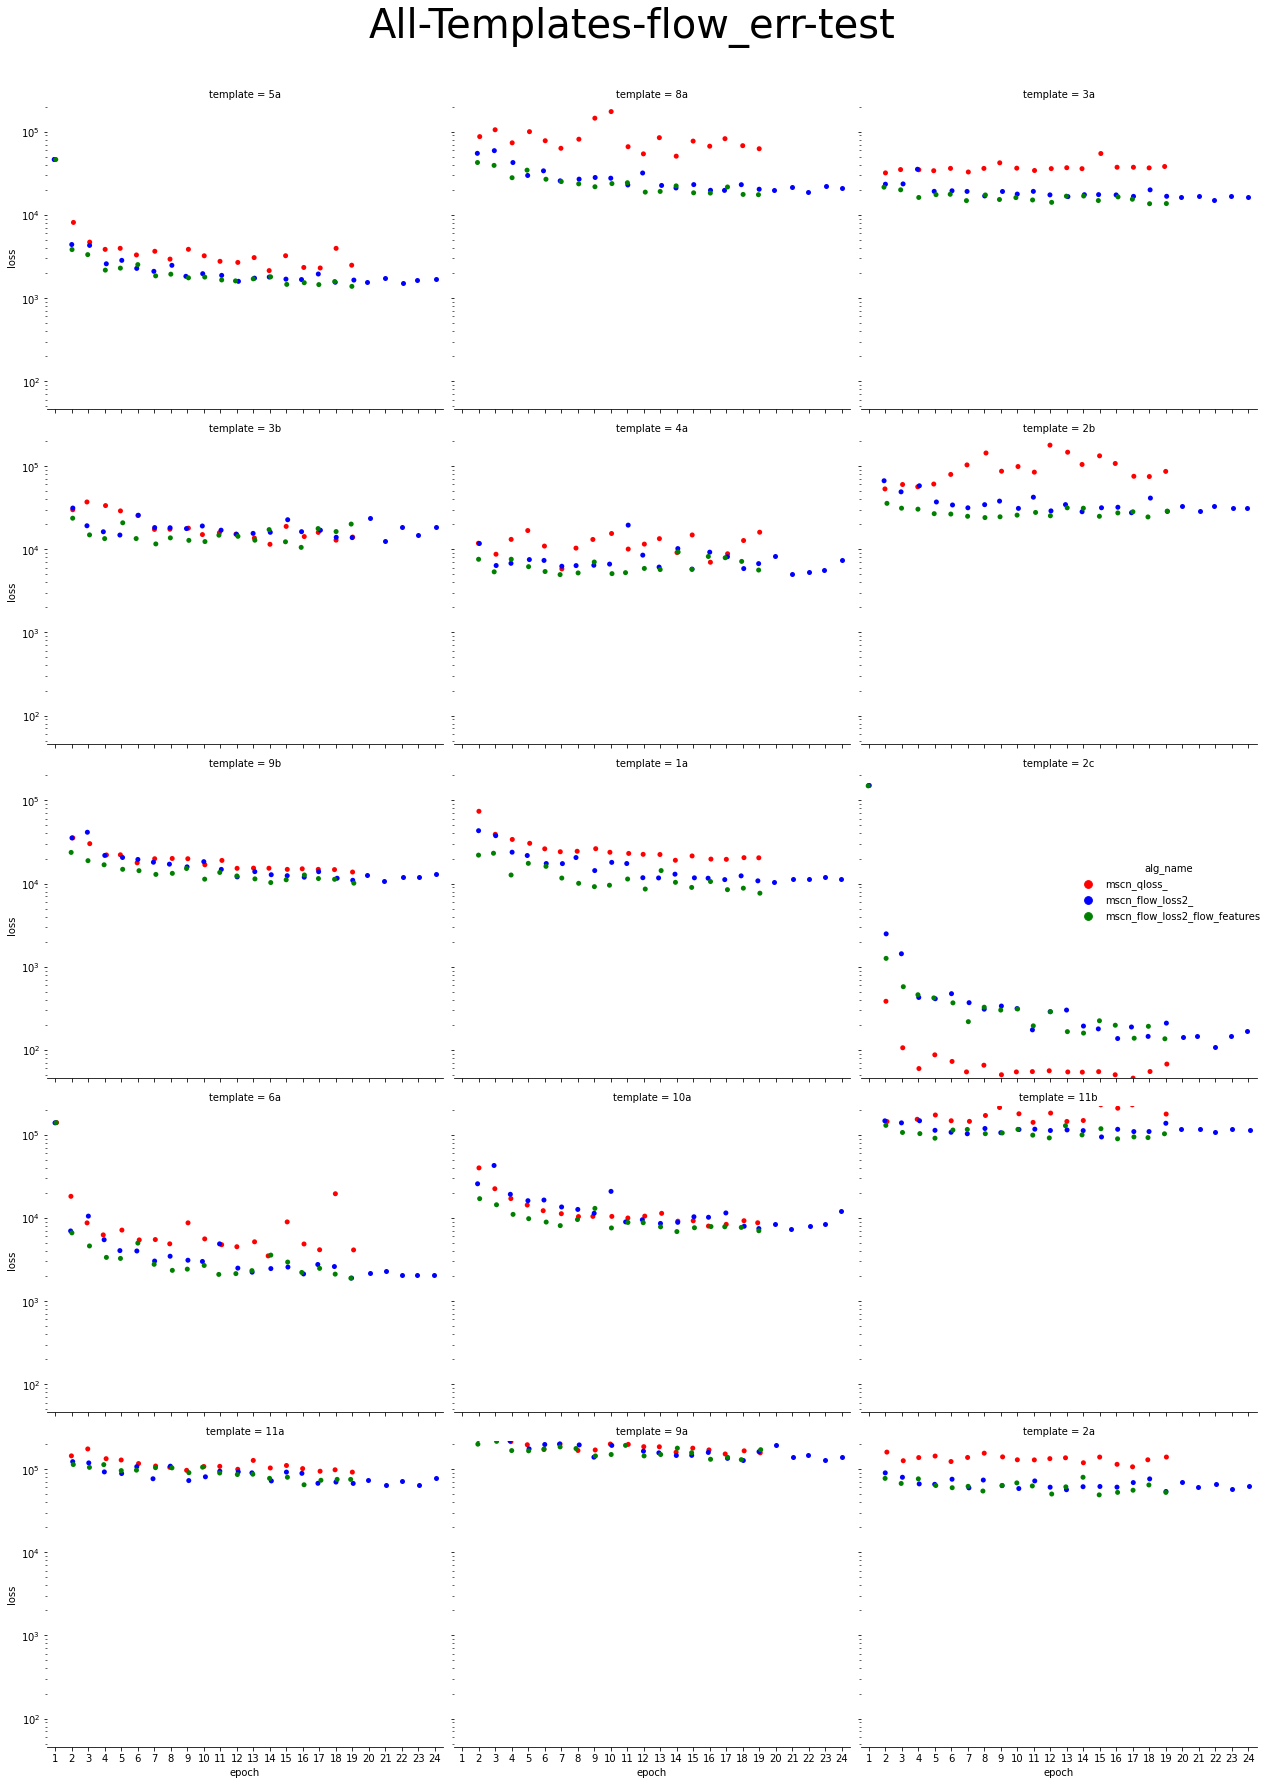

In [54]:
plot_loss(df, "flow_err", "train", "linear")
plot_loss(df, "flow_err", "test", "linear")
plot_loss_template(all_df, "flow_err", "train", "log")
plot_loss_template(all_df, "flow_err", "test", "log")

# Flow Ratio

## Flow_Loss / Optimal_Flow_loss

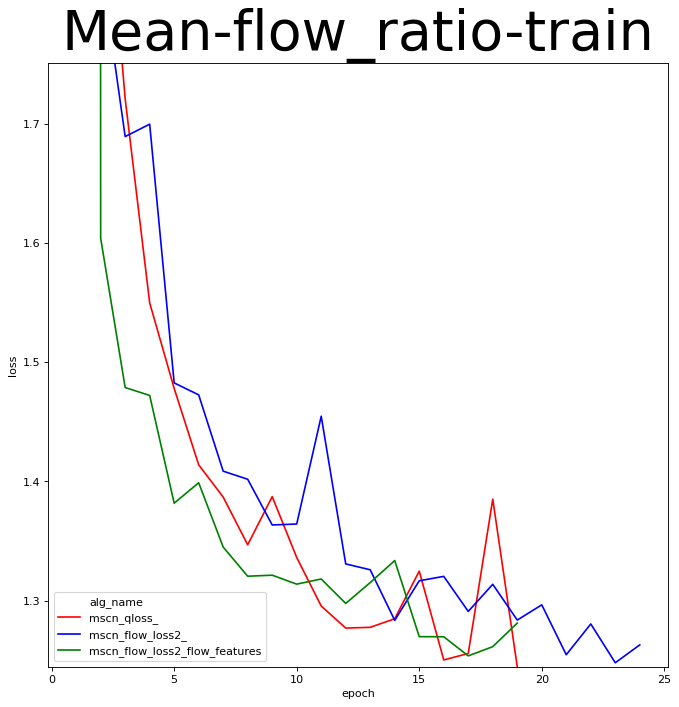

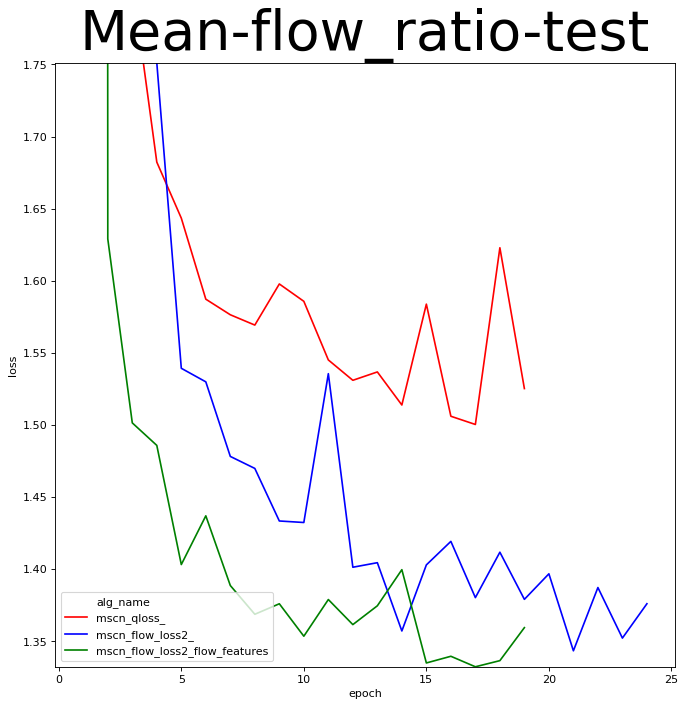

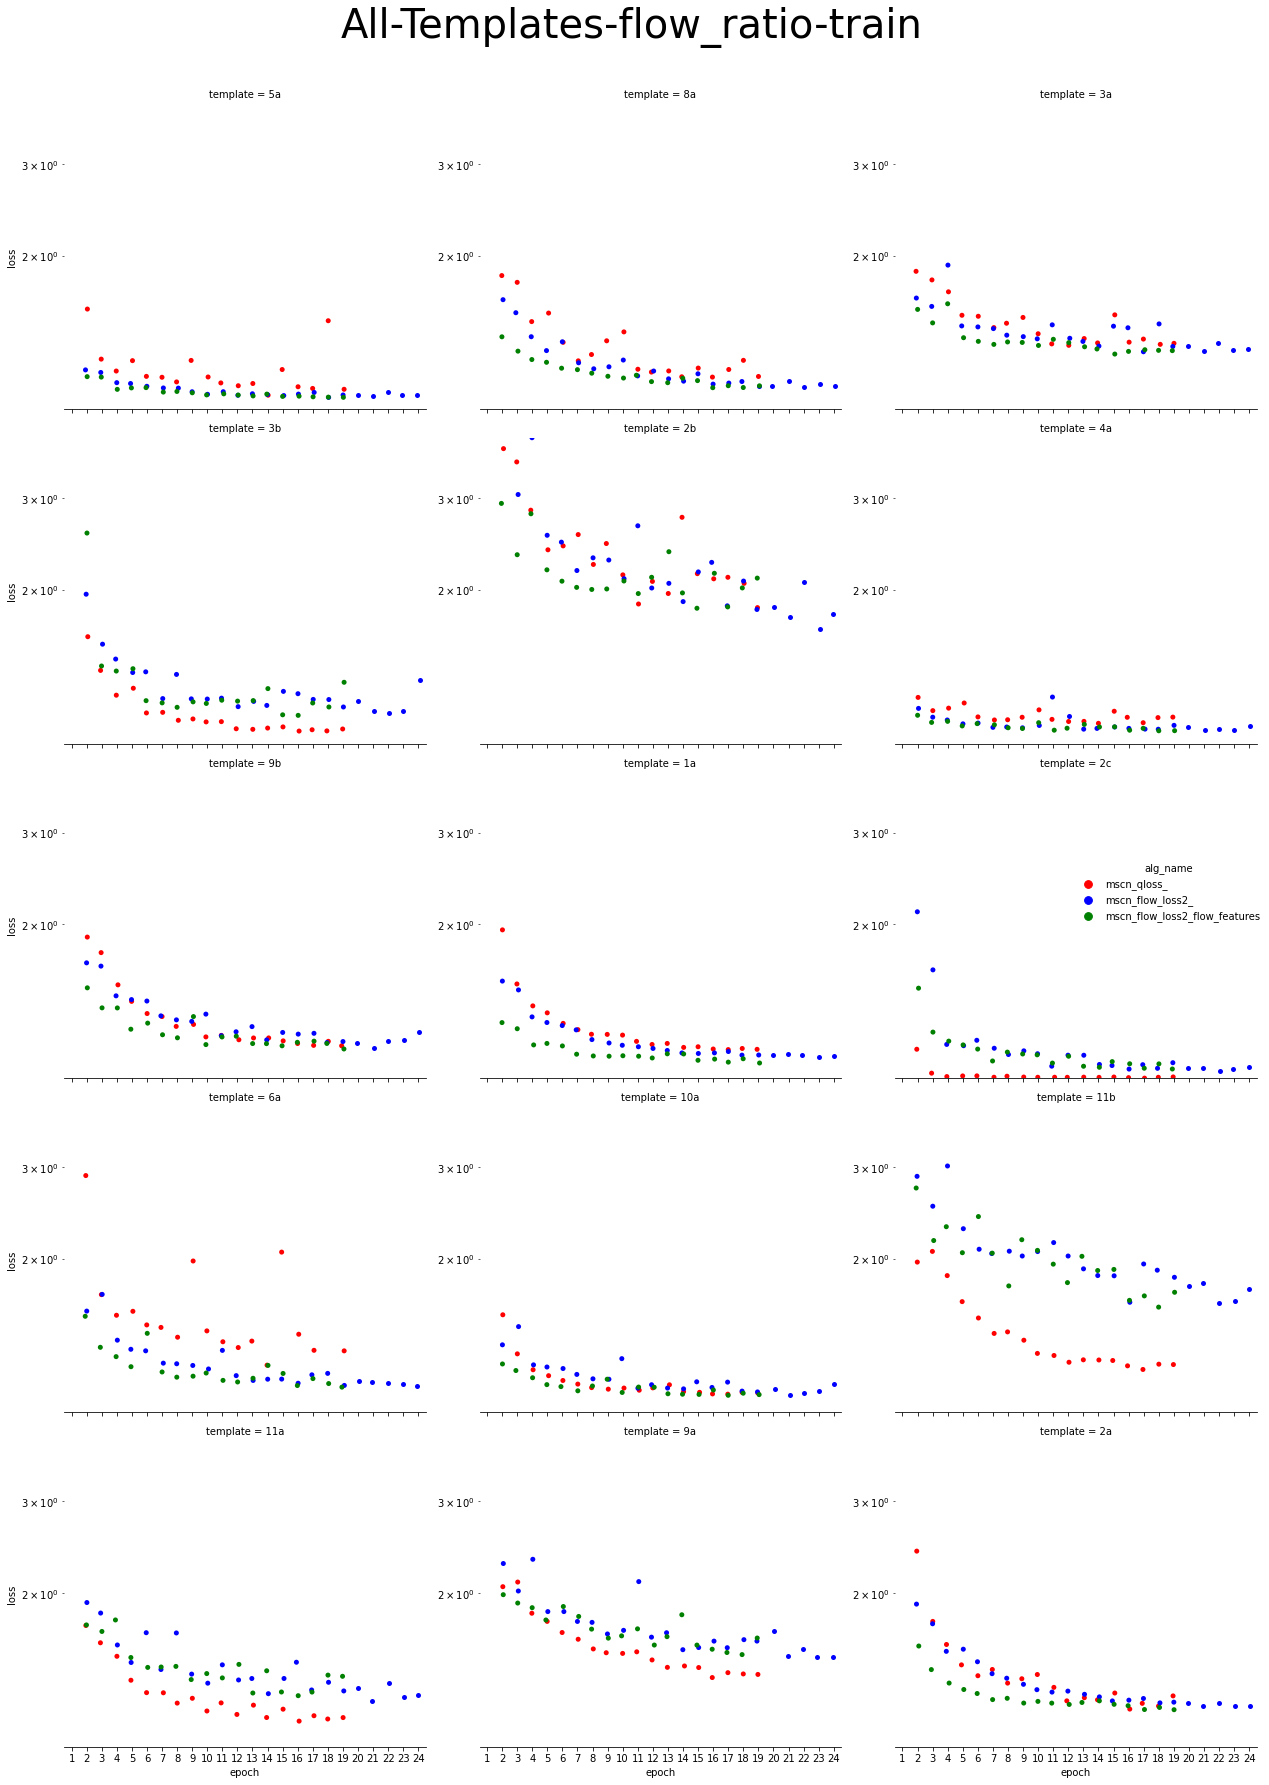

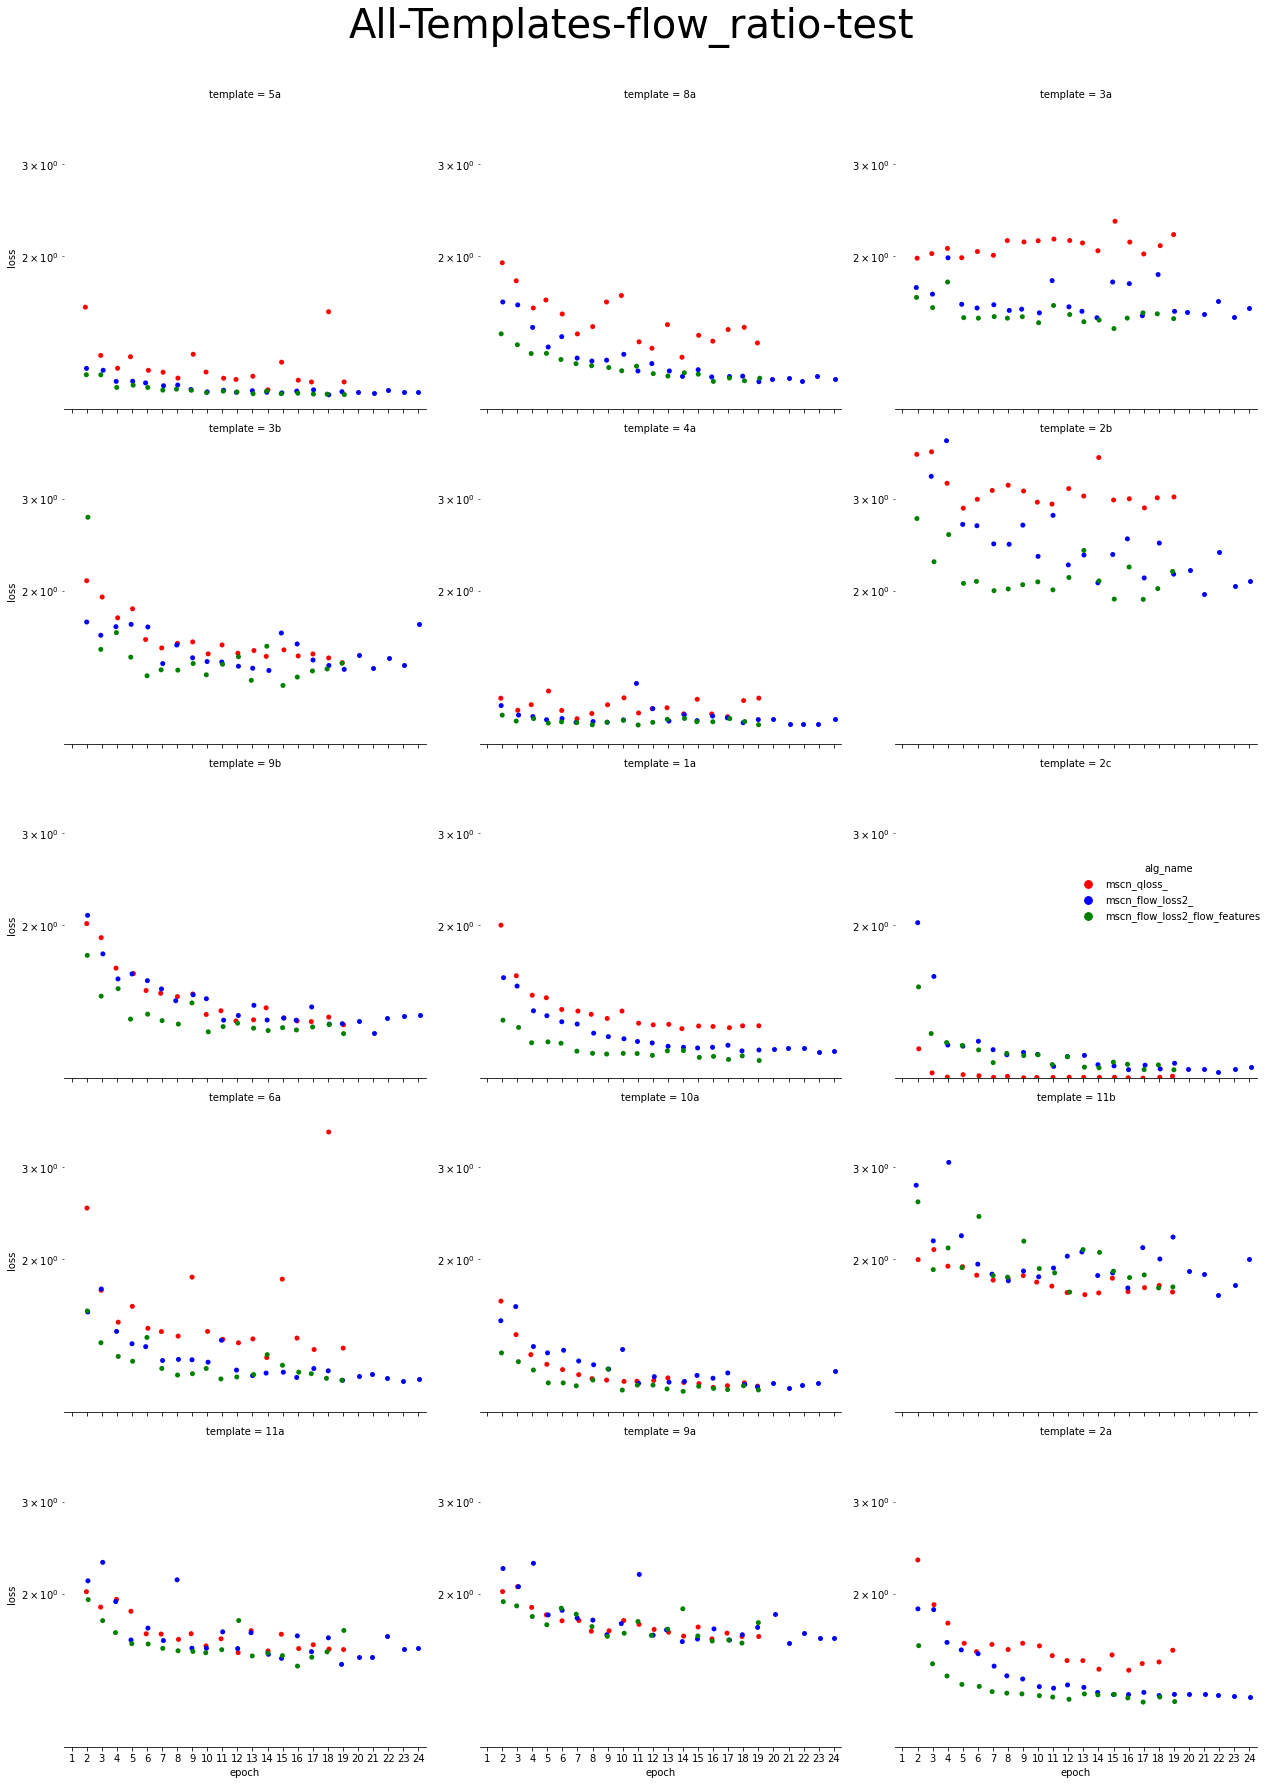

In [55]:
plot_loss(df, "flow_ratio", "train", "linear")
plot_loss(df, "flow_ratio", "test", "linear")
plot_loss_template(all_df, "flow_ratio", "train", "log")
plot_loss_template(all_df, "flow_ratio", "test", "log")

# MM1 Cost Model: Plan Error

## Simple Cost model that we used to define flow loss

## Plan Cost  - Optimal Plan Cost

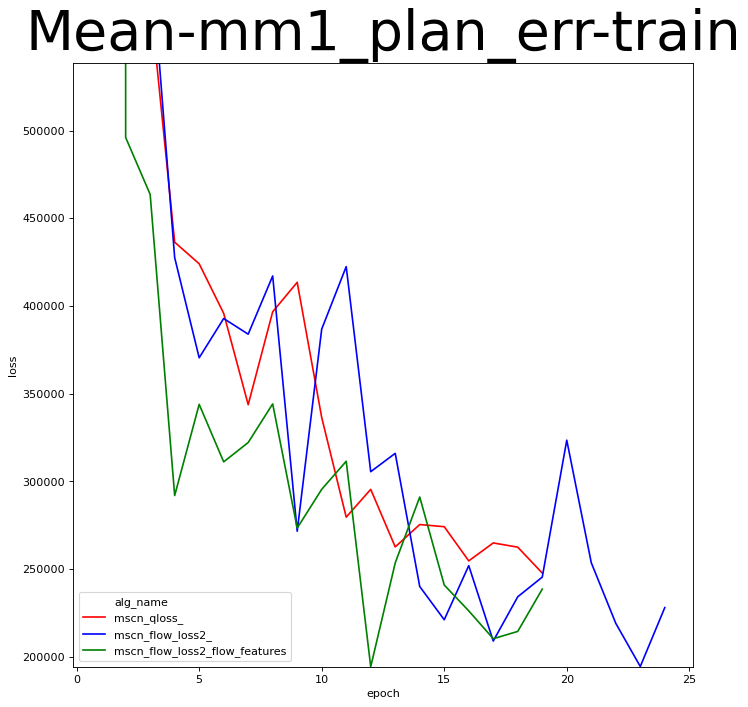

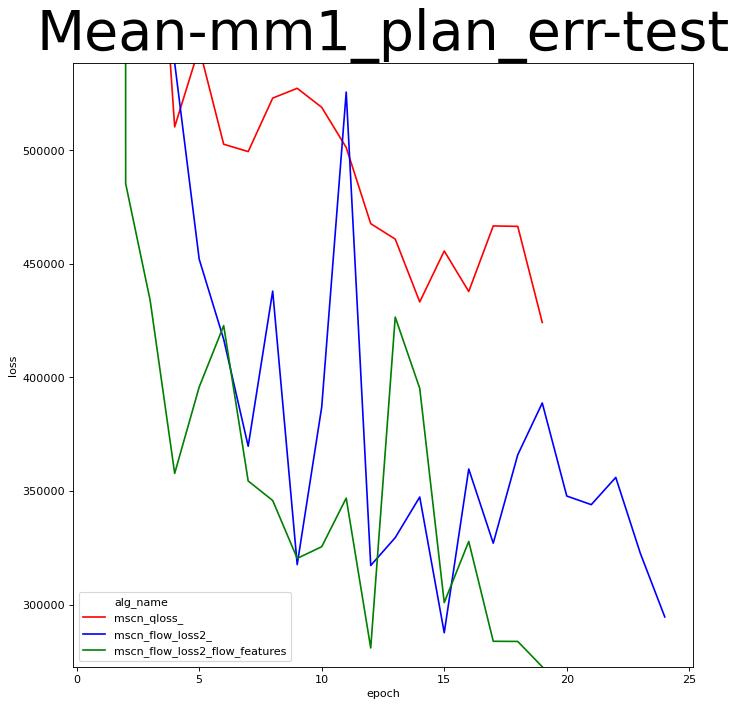

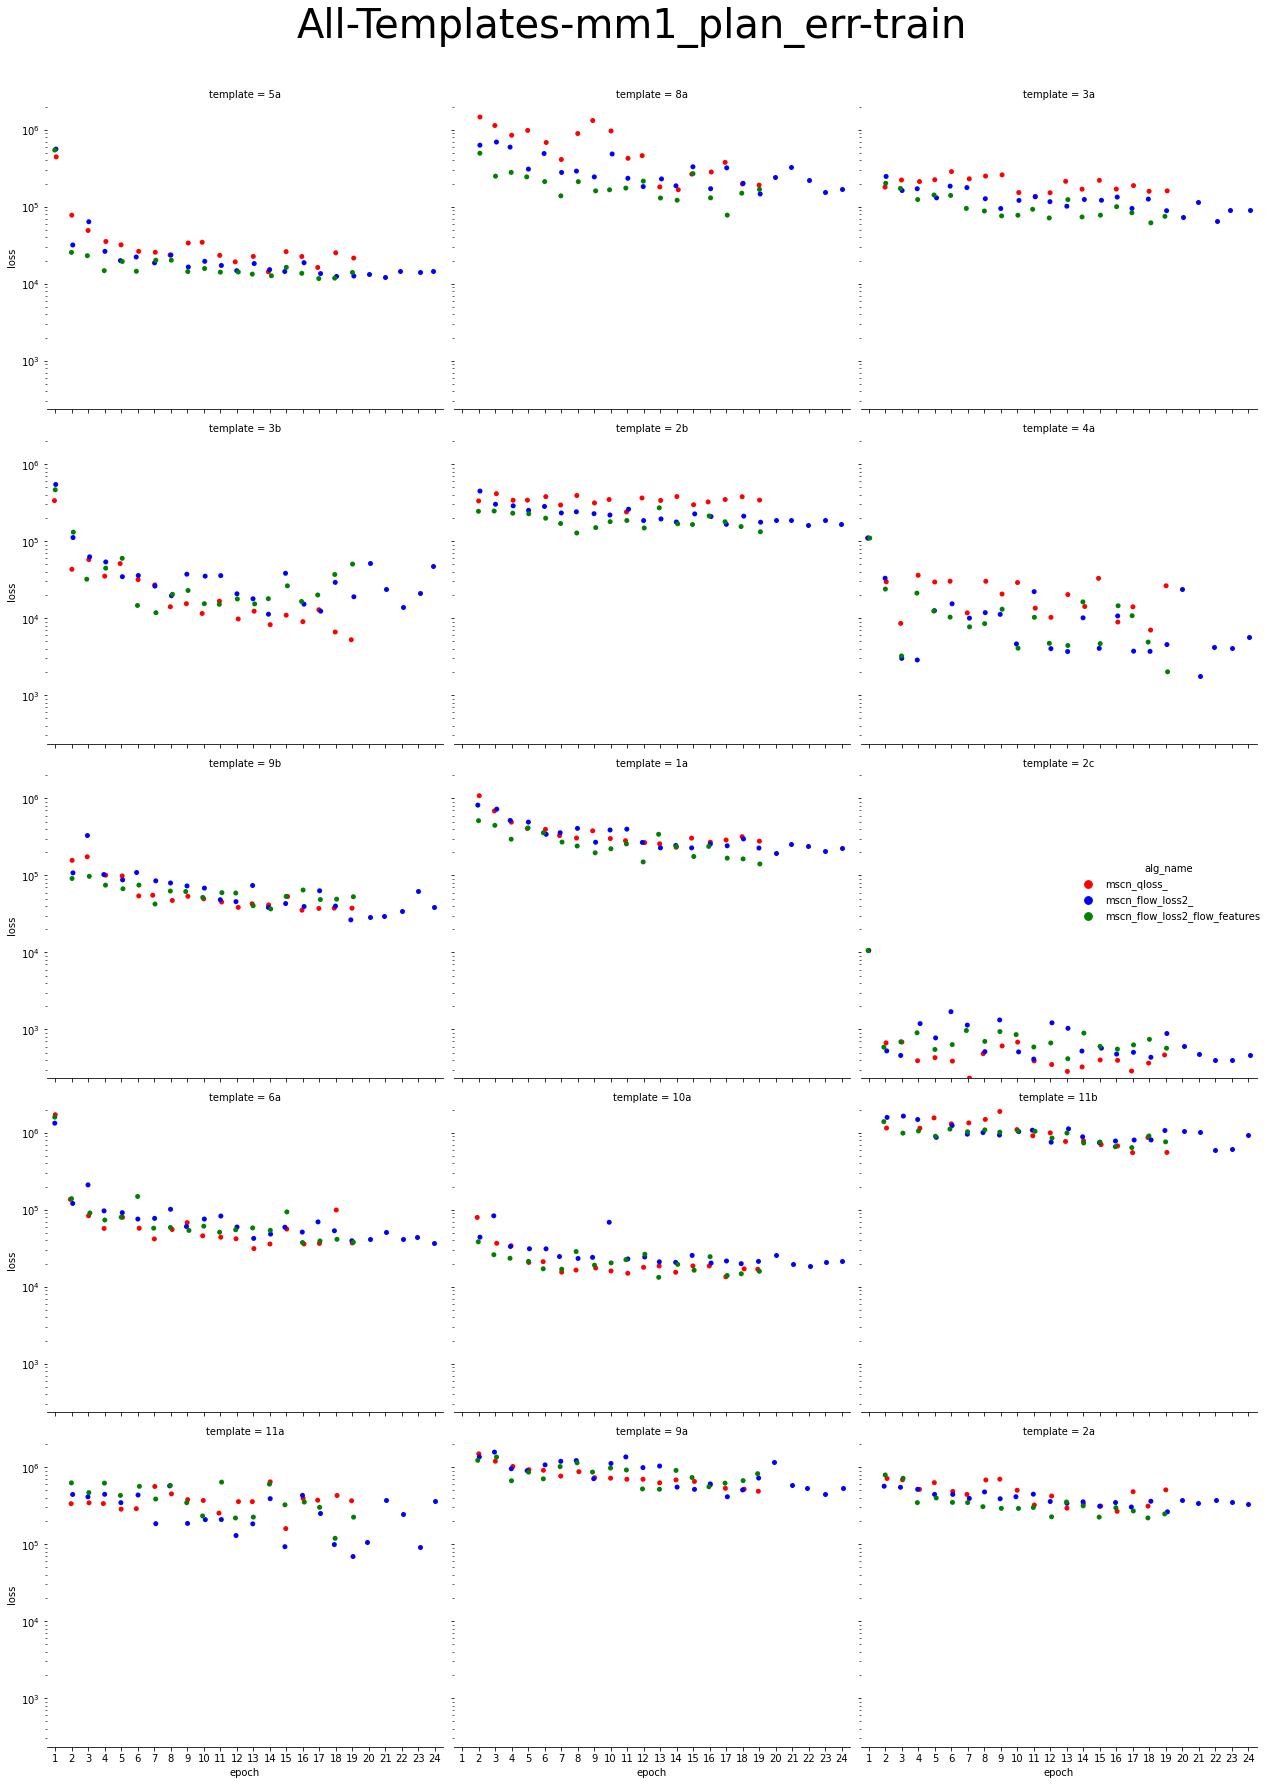

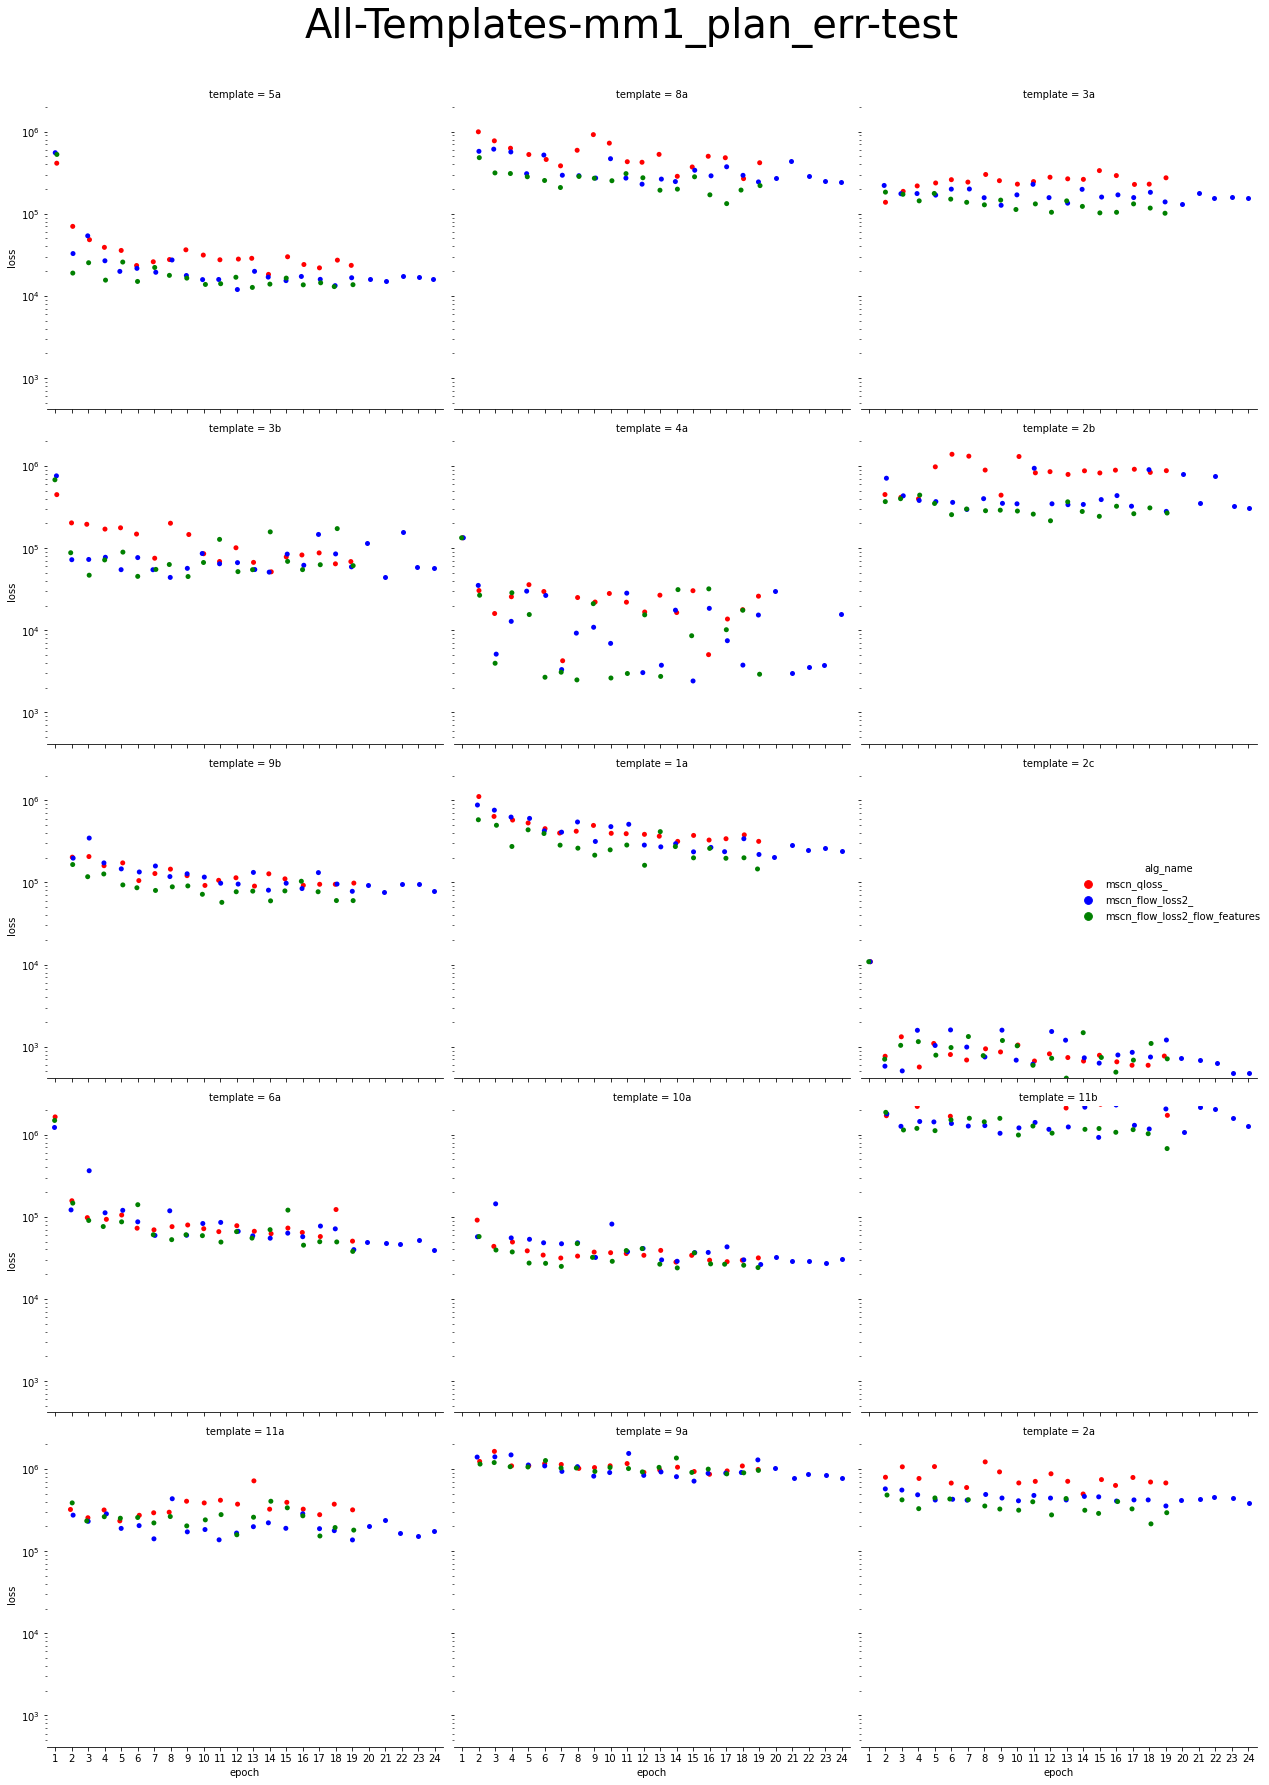

In [56]:
plot_loss(df, "mm1_plan_err", "train", "linear")
plot_loss(df, "mm1_plan_err", "test", "linear")
plot_loss_template(all_df, "mm1_plan_err", "train", "log")
plot_loss_template(all_df, "mm1_plan_err", "test", "log")

# MM1 Cost Model: Plan Ratio

## Simple Cost model that we used to define flow loss

## Plan Cost  / Optimal Plan Cost

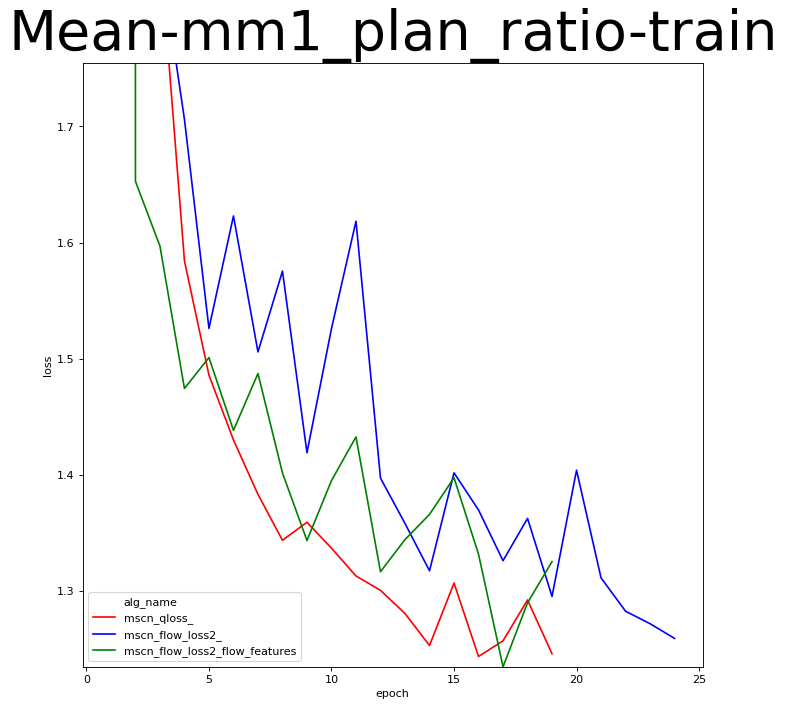

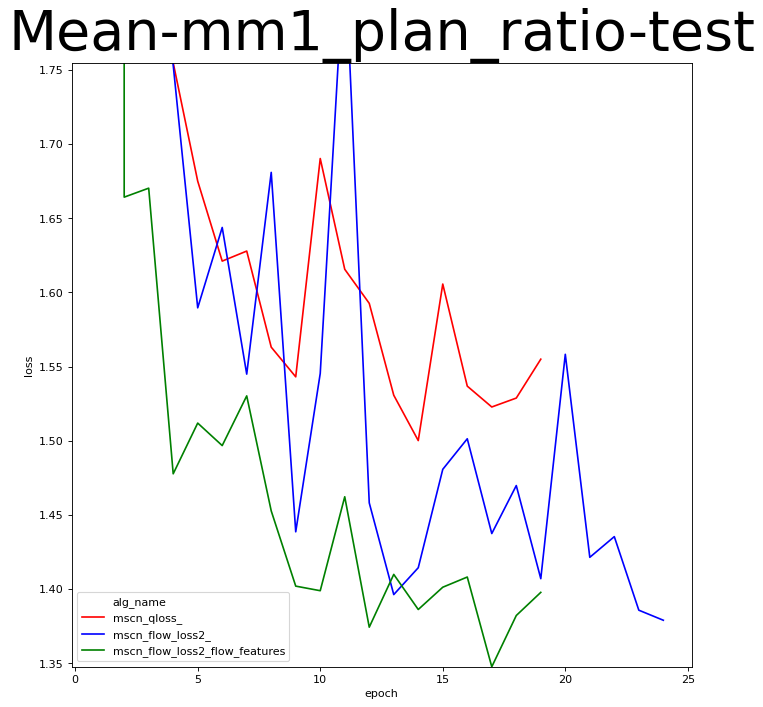

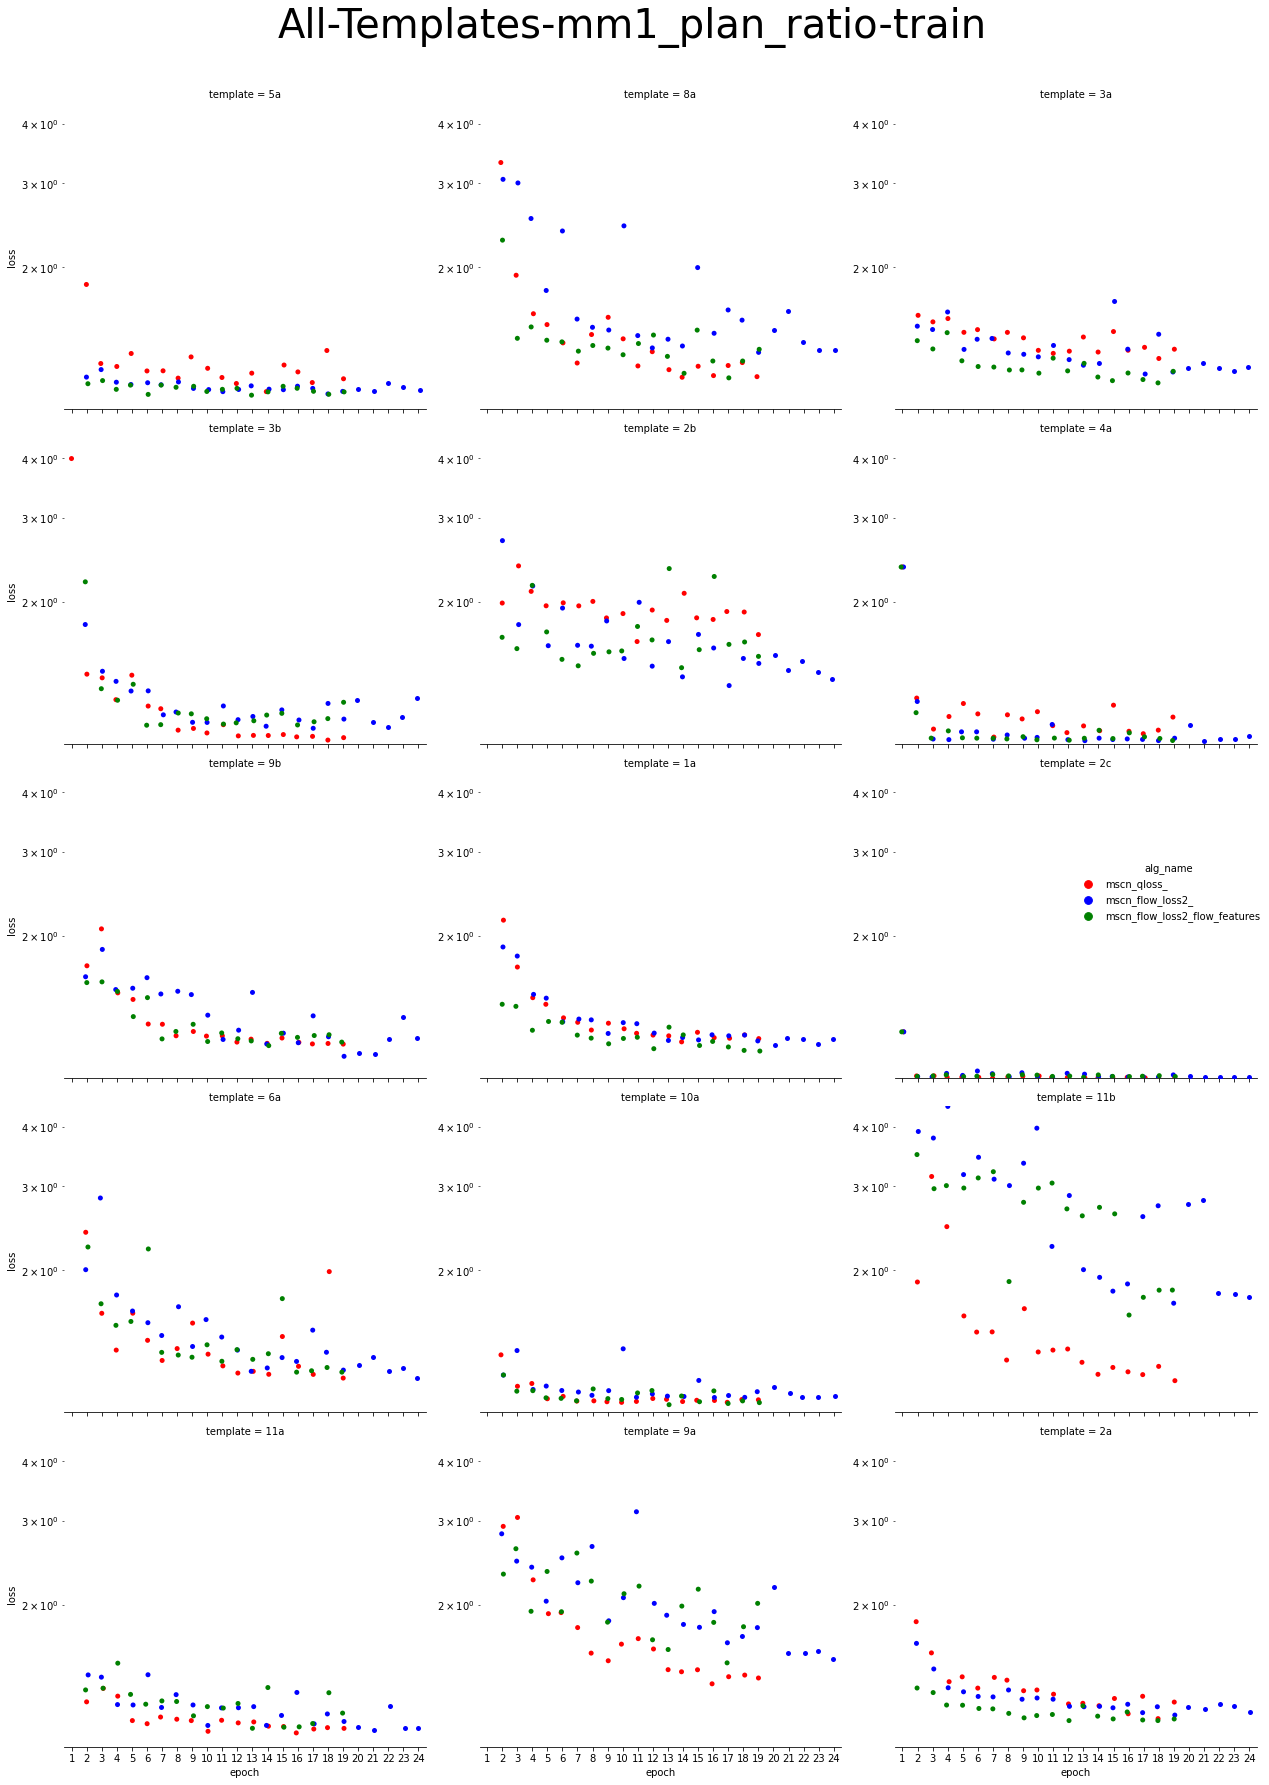

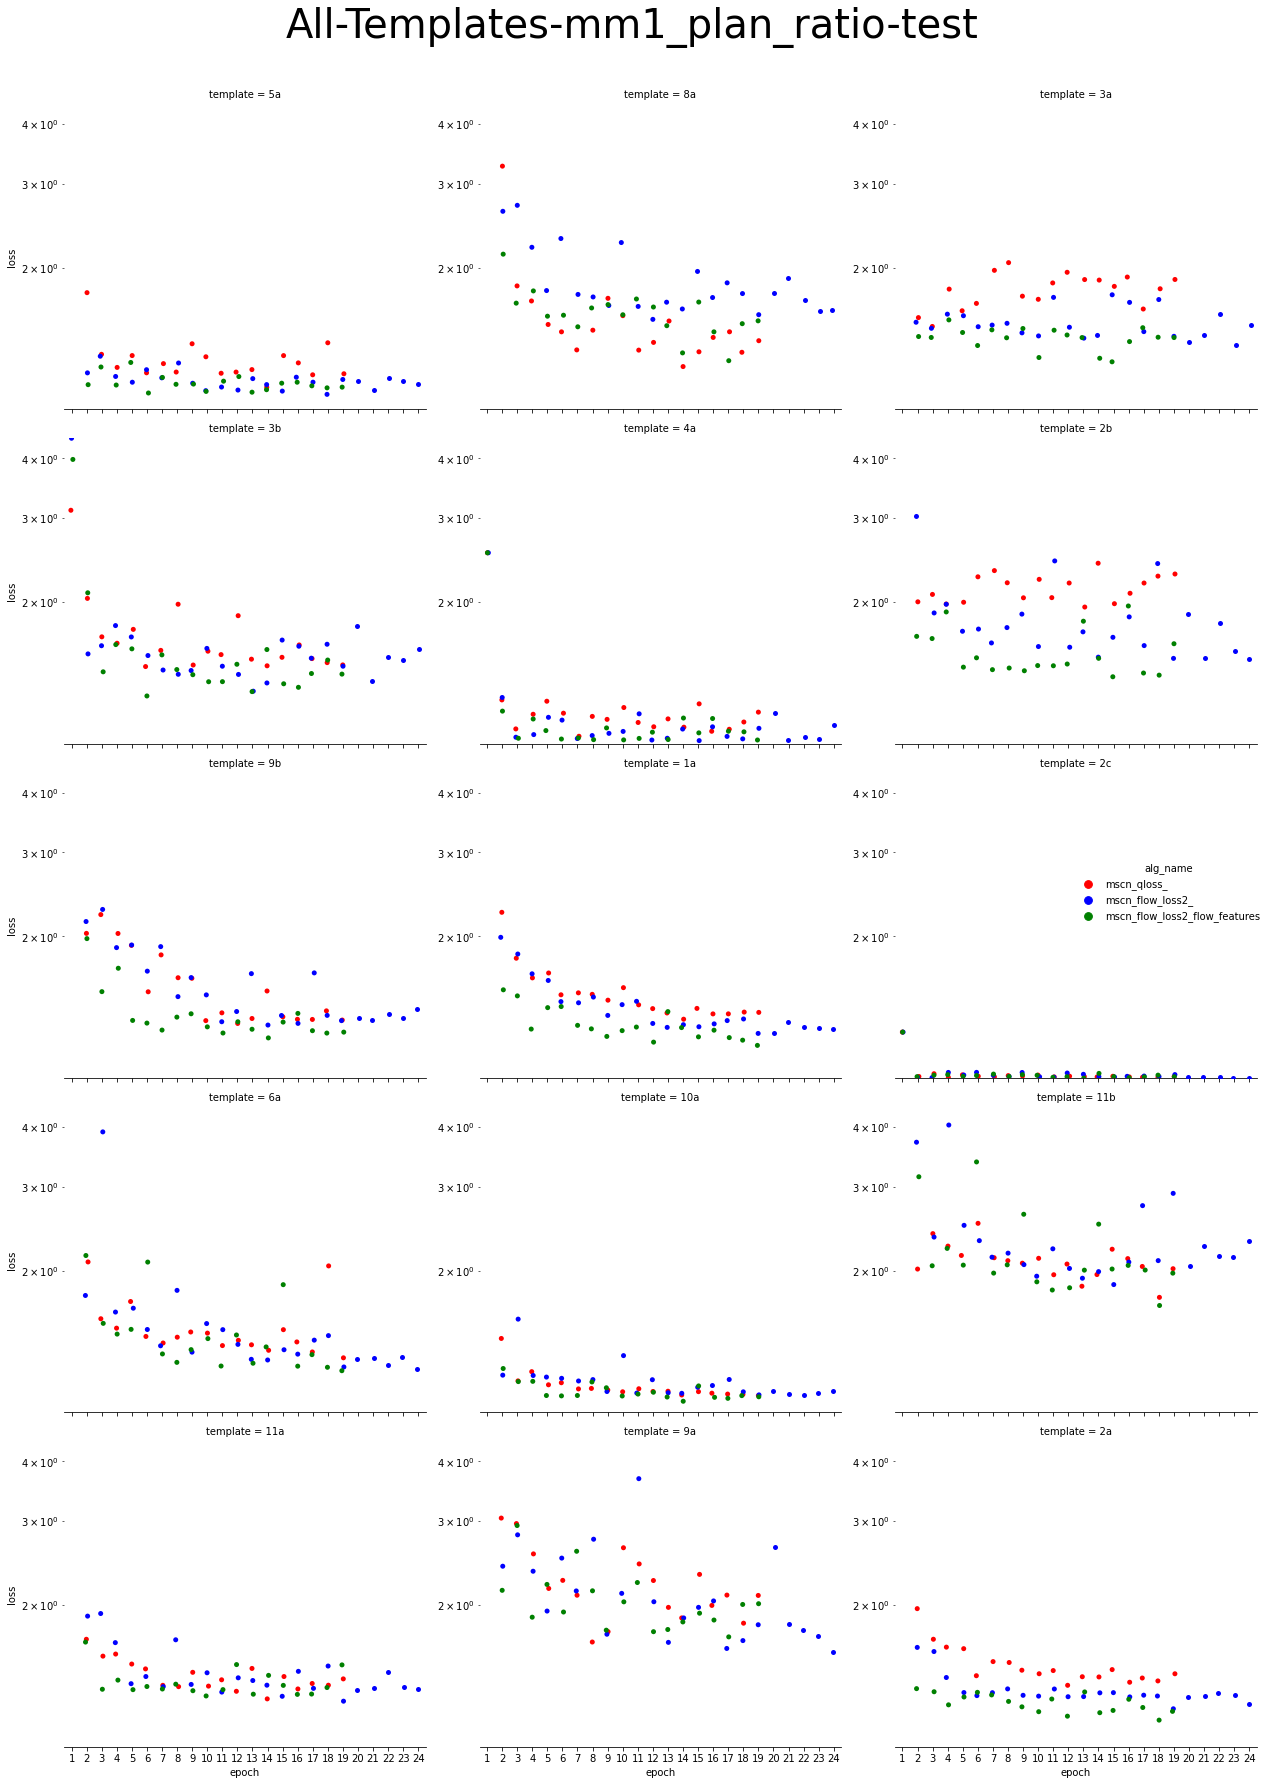

In [59]:
plot_loss(df, "mm1_plan_ratio", "train", "linear")
plot_loss(df, "mm1_plan_ratio", "test", "linear")
plot_loss_template(all_df, "mm1_plan_ratio", "train", "log")
plot_loss_template(all_df, "mm1_plan_ratio", "test", "log")

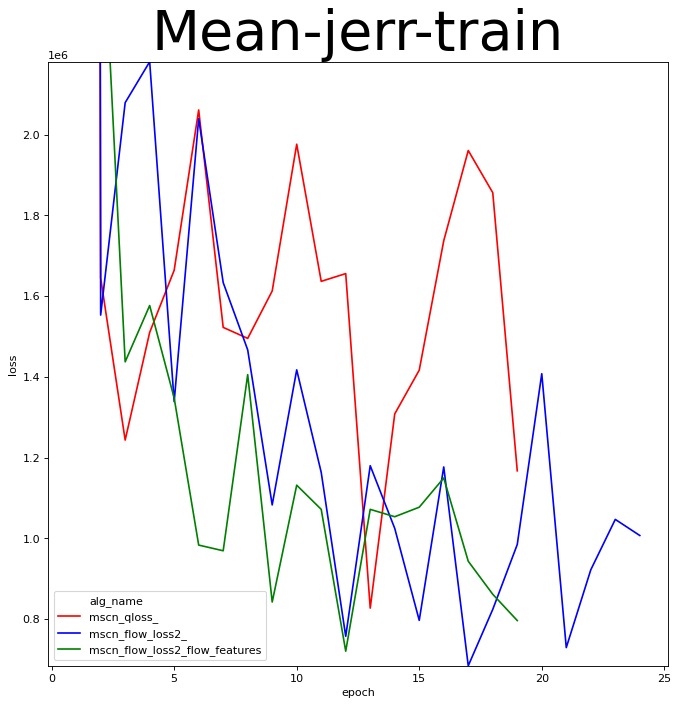

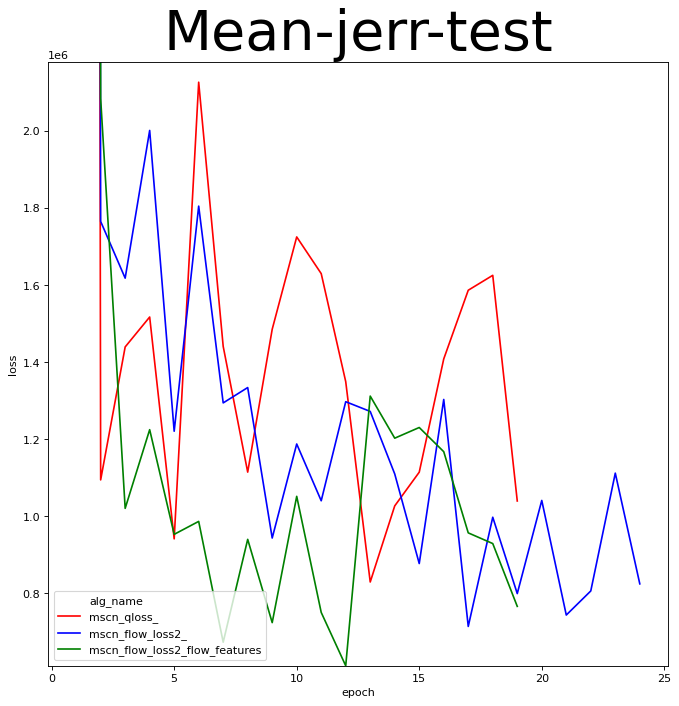

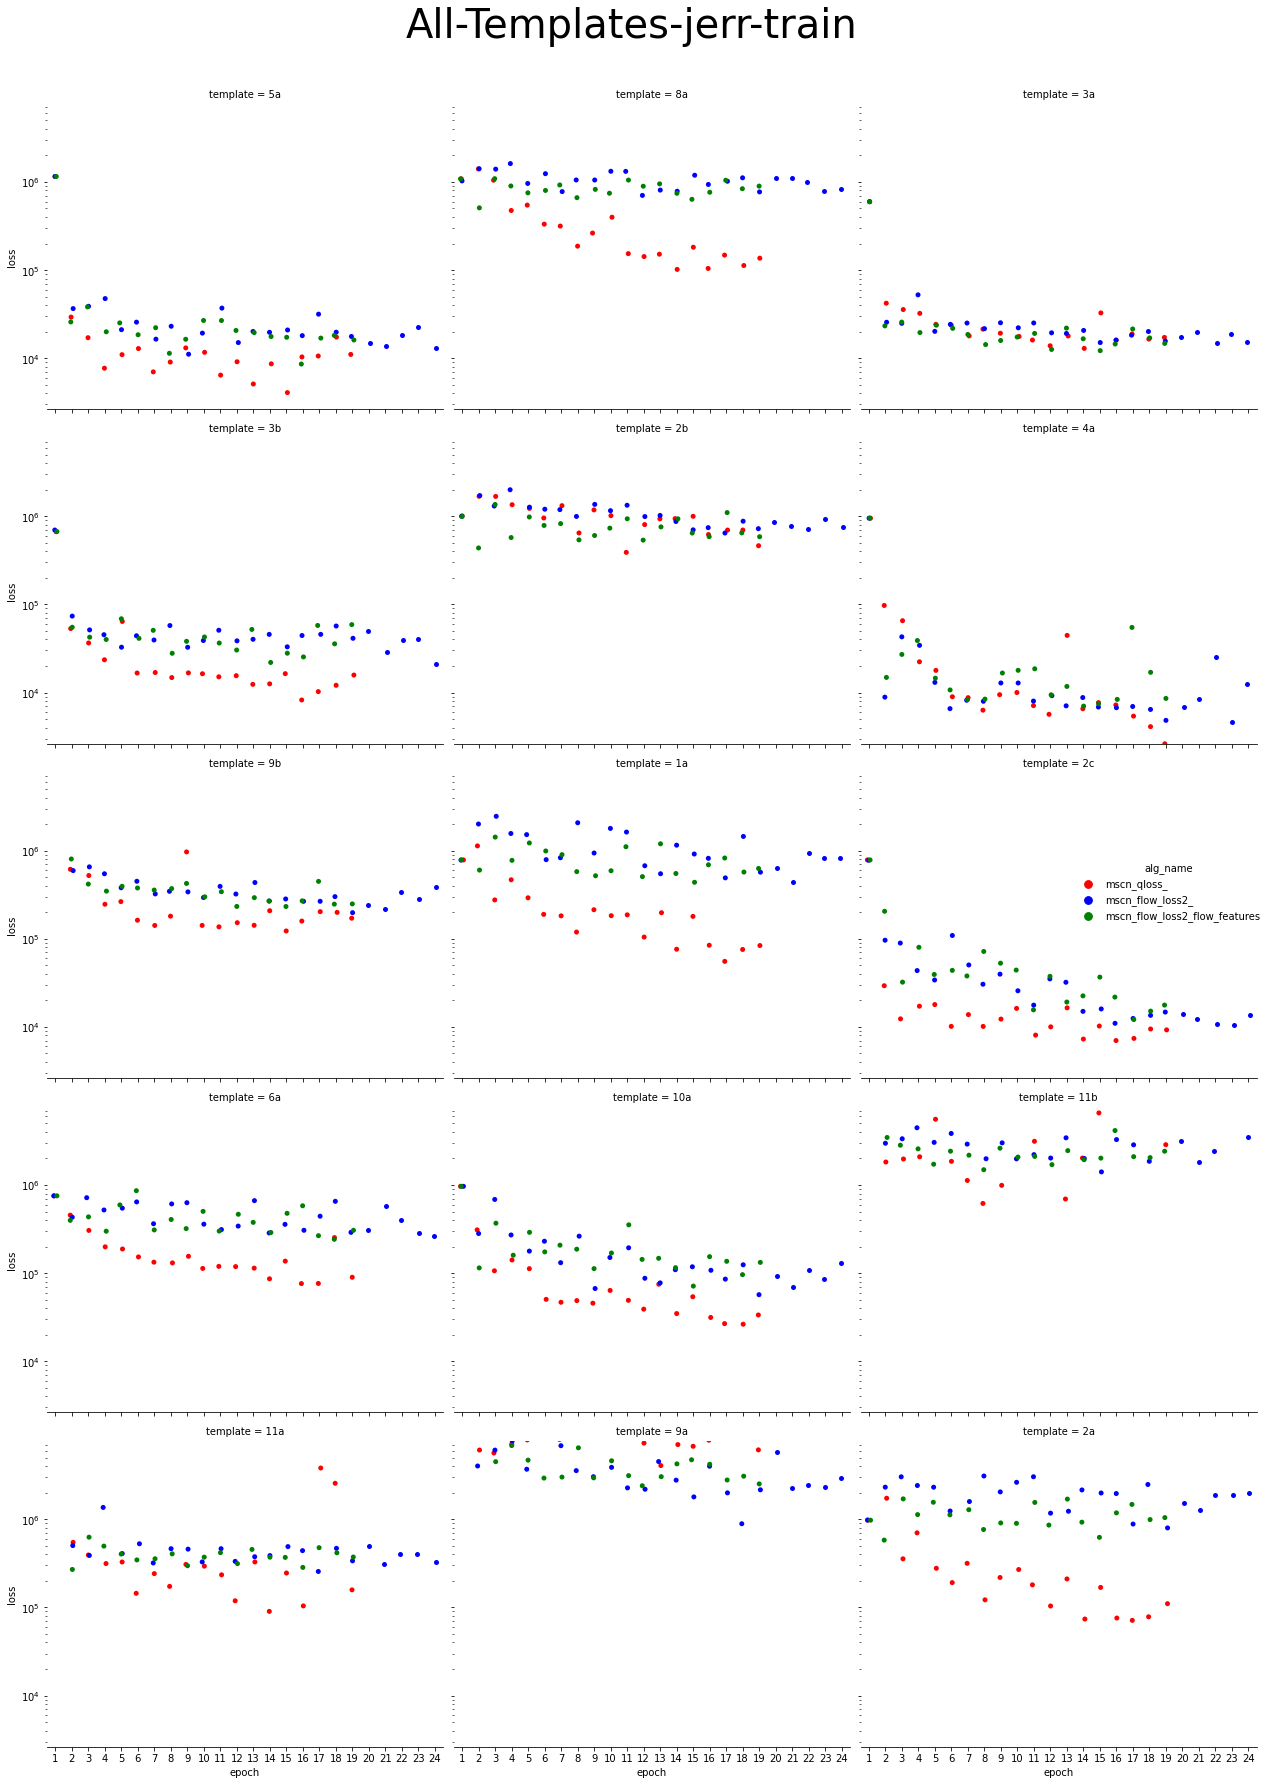

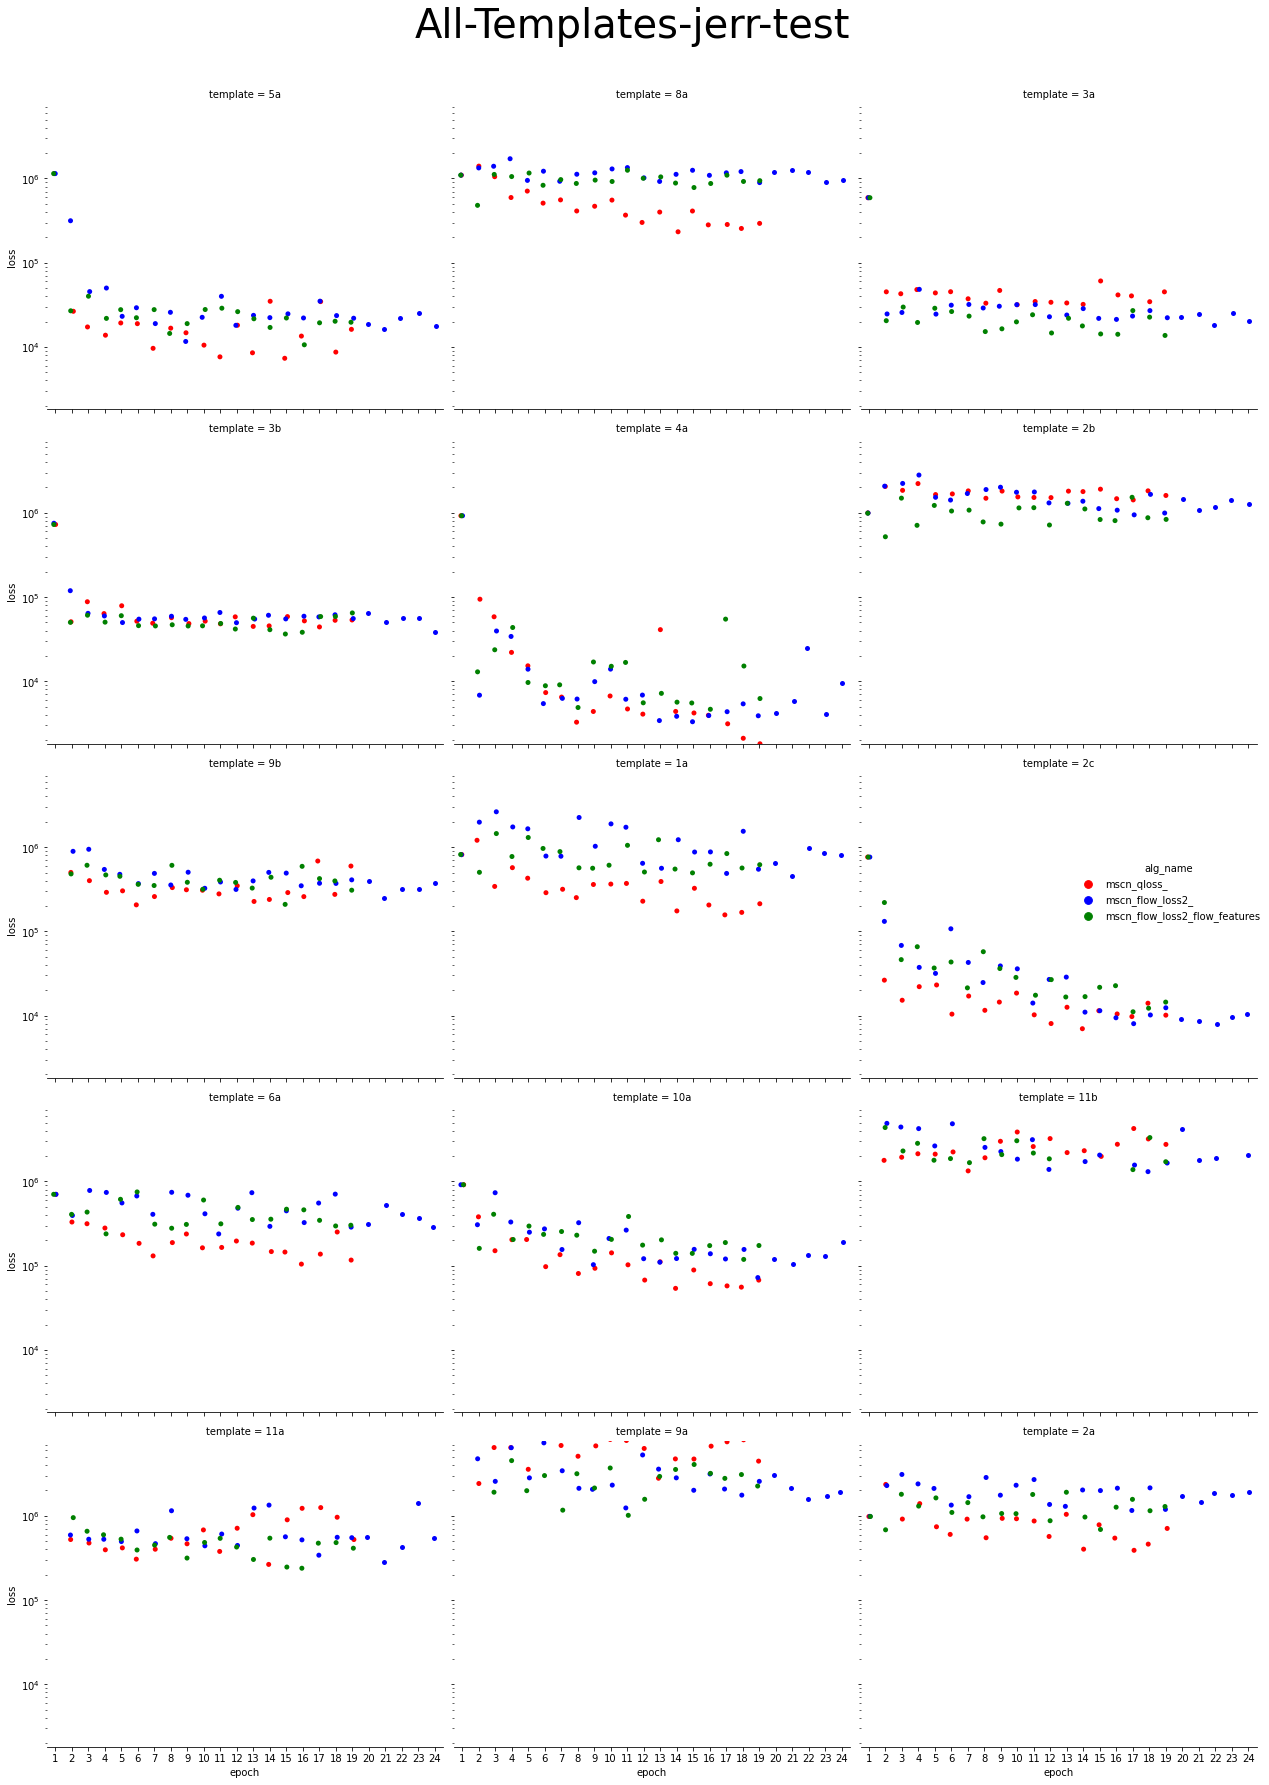

In [60]:
plot_loss(df, "jerr", "train", "linear")
plot_loss(df, "jerr", "test", "linear")
plot_loss_template(all_df, "jerr", "train", "log")
plot_loss_template(all_df, "jerr", "test", "log")

In [106]:
all_plans = get_all_plans(RES_DIR)

In [96]:
all_plans.keys()

Index(['epoch', 'query_name', 'jerr', 'plan', 'explain', 'qerr', 'alg', 'hls',
       'exp_name', 'priority'],
      dtype='object')